In [1]:
import pandas as pd 
import geopandas as gpd

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# apply saborn dark palette styling 
sns.set_palette("dark")

import sys 
# sys.path.append('/Users/gracecolverd/New_dataset')

from src.utils import join_pc_map_three_pc

import pandas as pd 
import sys 
sys.path.append('/Users/gracecolverd/City_clustering')
from src.city_cluster import load_bsdata

In [2]:
lk = pd.read_csv('/Volumes/T9/2024_Data_downloads/lookups/pcs_to_oa_mapping_census2021/PCD_OA21_LSOA21_MSOA21_LAD_AUG23_UK_LU.csv', encoding='latin1')
oa_lsoa = pd.read_csv('/Volumes/T9/2024_Data_downloads/lookups/OAs_to_LSOAs_to_MSOAs_to_LEP_to_LAD_(May_2022)_Lookup_in_England.csv')

lsoa2011_lsoa_2012 = pd.read_csv('/Volumes/T9/2024_Data_downloads/lookups/lsoa2011-2021/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Best_Fit_Lookup_for_EW_(V2).csv')
lsoa_city = pd.read_csv('/Volumes/T9/2024_Data_downloads/lookups/lsoa_city_2011/Lower_Layer_Super_Output_Area_(2011)_to_Major_Towns_and_Cities_(December_2015)_Lookup_in_England_and_Wales.csv')
ls21_city = lsoa_city.merge(lsoa2011_lsoa_2012, on=['LSOA11CD'])[['LSOA11CD', 'LSOA21CD', 'TCITY15CD' , 'TCITY15NM']].copy() 


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_77985/2027961417.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  lk = pd.read_csv('/Volumes/T9/2024_Data_downloads/lookups/pcs_to_oa_mapping_census2021/PCD_OA21_LSOA21_MSOA21_LAD_AUG23_UK_LU.csv', encoding='latin1')
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_77985/2027961417.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  oa_lsoa = pd.read_csv('/Volumes/T9/2024_Data_downloads/lookups/OAs_to_LSOAs_to_MSOAs_to_LEP_to_LAD_(May_2022)_Lookup_in_England.csv')


In [3]:
import numpy as np 

def get_city_age(city_data,   list_cols, names,age_cols ,age_names):
   
    city_data = city_data[city_data['TCITY15NM'].notna()].copy()
    # Create an empty DtaFrame to store the results
    res = pd.DataFrame()
    for idx, data in city_data.groupby('TCITY15NM'):
        city_dict = {'TCITY15NM': idx}

        for cols, name in zip(list_cols, names):
            city_dict[name] = data[cols].sum().sum() / data['all_res_total_buildings'].sum() * 100
        
        # Convert city_dict to a DataFrame and append to res
        city_df = pd.DataFrame([city_dict])
        res = pd.concat([res, city_df], ignore_index=True)

    res_age = pd.DataFrame() 
    for idx, data in city_data.groupby('TCITY15NM'): 
        city_res= {'TCITY15NM': idx}
        for cols, name in zip(age_cols, age_names):
            city_res[name] = data[cols].sum().sum() / data['all_res_total_buildings'].sum() * 100
        city_res = pd.DataFrame([city_res])
        res_age = pd.concat([res_age,city_res])

    age_city = res_age.merge(city_data[['TCITY15NM']].drop_duplicates(), on='TCITY15NM' ).set_index('TCITY15NM').reset_index()
    res_city = res.merge(age_city, on =['TCITY15NM'])
    return res_city

    
typ_cols = [ '2 storeys terraces with t rear extension_pct',
 '3-4 storey and smaller flats_pct',
 'Domestic outbuilding_pct',
 'Large detached_pct',
 'Large semi detached_pct',
 'Linked and step linked premises_pct',
 'Medium height flats 5-6 storeys_pct',
 
 'Planned balanced mixed estates_pct',
 'Semi type house in multiples_pct',
 'Small low terraces_pct',
 'Standard size detached_pct',
 'Standard size semi detached_pct',
 'Tall flats 6-15 storeys_pct',
 'Tall terraces 3-4 storeys_pct',
 'Very large detached_pct',
 'Very tall point block flats_pct']

def compute_entropy(probs):
    """Compute the Shannon entropy of a probability distribution."""
    return -np.sum(probs * np.log2(probs + 1e-9))

def calculate_typology_entropy(df, typology_columns):
    # Group by city
    city_groups = df.groupby('TCITY15CD')

    # Initialize a list to store entropy values
    entropy_values = []

    # Calculate entropy for each city
    for city, group in city_groups:
        # Calculate the mean typology mix for the city
        typology_means = group[typology_columns].mean()
        
        # Normalize the typology means to get a probability distribution
        typology_probs = typology_means / typology_means.sum()
        
        # Compute the entropy for the city
        entropy = compute_entropy(typology_probs)
        
        # Append the entropy value with the city name
        entropy_values.append({'TCITY15CD': city, 'entropy': entropy})
    
    # Convert the entropy values list to a DataFrame
    entropy_df = pd.DataFrame(entropy_values)

    # Merge the entropy values back into the original DataFrame
    df = df.merge(entropy_df, on='TCITY15CD',  how='left')

    return df




In [4]:
def load_proc_cen(path, name_col, cen_map, attr_name):
    raw = pd.read_csv(path)
    df = raw.merge(oa_lsoa, left_on='Output Areas Code', right_on='OA21CD').merge(ls21_city, on='LSOA21CD')
    result = aggregate_cen(df, name_col, cen_map, attr_name)
    return reshape_cen(result, attr_name)
    


def aggregate_cen(df, name_col, cen_map, attr_name):
    # Map the detailed economic activities to higher-level categories
    df[attr_name] = df[name_col].map(cen_map)
    
    # Group by city and economic activity, and sum the counts
    grouped = df.groupby(['TCITY15NM', attr_name])['Observation'].sum().reset_index()
    
    # Calculate total counts per city
    total_counts = grouped.groupby('TCITY15NM')['Observation'].sum().reset_index()
    total_counts.columns = ['TCITY15NM', 'Total Observation']
    
    # Merge total counts back to the grouped data
    merged = pd.merge(grouped, total_counts, on='TCITY15NM')
    
    # Calculate the percentage
    merged['Percentage'] = (merged['Observation'] / merged['Total Observation']) * 100
    
    return merged[['TCITY15NM', attr_name , 'Observation', 'Percentage']]



def reshape_cen(df, attr_name ):
    # Pivot the DataFrame to have attributes as columns
    pivoted = df.pivot(index='TCITY15NM', columns=attr_name, values='Percentage')
    # Reset the index to make TCITY15NM a column again
    pivoted.reset_index(inplace=True)
    # Rename columns to include 'perc_' prefix
    pivoted.columns.name = None
    pivoted.columns = [f'perc_{col.lower().replace(" ", "_")}' if col != 'TCITY15NM' else col for col in pivoted.columns]
    return pivoted  


occ_mapping = { 'One-person household': 'One-person household',
       'Single family household: All aged 66 years and over': 'Single family household',
       'Single family household: Couple family household': 'Single family household',
       'Single family household: Lone parent household': 'Single family household',
       'Other household types': 'Other households' 
       } 


# Updated mapping with economic activity categories
economic_activity_mapping = {
    'Does not apply': 'Does not apply',
    'Economically active (excluding full-time students): In employment: Employee: Part-time': 'Economically Active: Employed',
    'Economically active (excluding full-time students): In employment: Employee: Full-time': 'Economically Active: Employed',
    'Economically active (excluding full-time students): In employment: Self-employed with employees: Part-time': 'Economically Active: Employed',
    'Economically active (excluding full-time students): In employment: Self-employed with employees: Full-time': 'Economically Active: Employed',
    'Economically active (excluding full-time students): In employment: Self-employed without employees: Part-time': 'Economically Active: Employed',
    'Economically active (excluding full-time students): In employment: Self-employed without employees: Full-time': 'Economically Active: Employed',
    'Economically active (excluding full-time students): Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks': 'Economically Active: Unemployed',
    'Economically active and a full-time student: In employment: Employee: Part-time': 'Economically Active: Employed',
    'Economically active and a full-time student: In employment: Employee: Full-time': 'Economically Active: Employed',
    'Economically active and a full-time student: In employment: Self-employed with employees: Part-time': 'Economically Active: Employed',
    'Economically active and a full-time student: In employment: Self-employed with employees: Full-time': 'Economically Active: Employed',
    'Economically active and a full-time student: In employment: Self-employed without employees: Part-time': 'Economically Active: Employed',
    'Economically active and a full-time student: In employment: Self-employed without employees: Full-time': 'Economically Active: Employed',
    'Economically active and a full-time student: Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks': 'Economically Active: Unemployed',
    'Economically inactive: Retired': 'Economically Inactive',
    'Economically inactive: Student': 'Economically Inactive',
    'Economically inactive: Looking after home or family': 'Economically Inactive',
    'Economically inactive: Long-term sick or disabled': 'Economically Inactive',
    'Economically inactive: Other': 'Economically Inactive'
}



ethnicity_mapping = {
    'Asian, Asian British or Asian Welsh: Bangladeshi': 'Asian',
    'Asian, Asian British or Asian Welsh: Chinese': 'Asian',
    'Asian, Asian British or Asian Welsh: Indian': 'Asian',
    'Asian, Asian British or Asian Welsh: Pakistani': 'Asian',
    'Asian, Asian British or Asian Welsh: Other Asian': 'Asian',
    'Black, Black British, Black Welsh, Caribbean or African: African': 'Black',
    'Black, Black British, Black Welsh, Caribbean or African: Caribbean': 'Black',
    'Black, Black British, Black Welsh, Caribbean or African: Other Black': 'Black',
    'Mixed or Multiple ethnic groups: White and Asian': 'Mixed',
    'Mixed or Multiple ethnic groups: White and Black African': 'Mixed',
    'Mixed or Multiple ethnic groups: White and Black Caribbean': 'Mixed',
    'Mixed or Multiple ethnic groups: Other Mixed or Multiple ethnic groups': 'Mixed',
    'White: English, Welsh, Scottish, Northern Irish or British': 'White',
    'White: Irish': 'White',
    'White: Gypsy or Irish Traveller': 'White',
    'White: Roma': 'White',
    'White: Other White': 'White',
    'Other ethnic group: Arab': 'Other',
    'Other ethnic group: Any other ethnic group': 'Other',
    'Does not apply': 'Other'
}

def load_census(df_list):
    i = 0
    for df in df_list:
        if i ==0:
            fin = df
            i+=1 
        else:
            fin = fin.merge(df, on='TCITY15NM')
    return fin 

In [5]:
path = '/Volumes/T9/2024_Data_downloads/census_2021/household_bedroom_number/RM059-2021-3-filtered-2024-03-04T15_28_43Z.csv'
name_col = 'Household composition (6 categories)'
cen_map = occ_mapping
attr_name = 'occupancy'
cen = load_proc_cen(path, name_col, cen_map , attr_name)

path = '/Volumes/T9/2024_Data_downloads/census_2021/economic_activity/TS066-2021-6-filtered-2024-03-04T15_29_15Z.csv'
name_col = 'Economic activity status (20 categories)'
cen_map = economic_activity_mapping
attr_name = 'economic_activity'
econ = load_proc_cen(path, name_col, cen_map , attr_name)



path =  '/Volumes/T9/2024_Data_downloads/census_2021/ethnic_group/TS021-2021-3-filtered-2024-03-05T10_06_33Z.csv'
name_col = 'Ethnic group (20 categories)'
cen_map = ethnicity_mapping
attr_name = 'ethnicity'
ethnic = load_proc_cen(path, name_col, cen_map , attr_name)

census_city = load_census([cen, ethnic, econ])

In [20]:
# def load_bsdata(data):
#     data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True )

#     city_data = data.merge(ls21_city, left_on='lsoa11cd', right_on ='LSOA11CD')
#     outp= calculate_typology_entropy(city_data, typ_cols)

#     wrk = outp[~outp['total_gas'].isna()].copy() 
#     wrk['av_eui_h'] = wrk['total_gas'] / wrk['all_res_heated_vol_h_total']
#     wrk['perc_diff_meters'] = wrk.diff_gas_meters_uprns_res / wrk.num_meters_gas

#     return city_data,  wrk 


In [54]:
wrkv3

postcode  all_types_total_buildings  all_types_uprn_count_total  \
0        PL9 7ER                       51.0                        35.0   
1        PL9 7QP                       62.0                        30.0   
9        PL9 7QX                       11.0                        10.0   
10       PL9 7BN                       21.0                        22.0   
12       PL9 7BL                       16.0                        16.0   
...          ...                        ...                         ...   
1459311   E3 3EU                       47.0                        54.0   
1459312   E3 3HP                       22.0                        71.0   
1459313   E3 3PD                       45.0                        41.0   
1459314   E3 3PE                        9.0                         8.0   
1459315   E3 4ED                        5.0                        60.0   

         comm_alltypes_count  unknown_alltypes  all_res_total_buildings  \
0                        0.0               2.0                     49.0   
1                        0.0               0.0                     62.0   
9                        0.0               1.0                     10.0   
10                       0.0               1.0                     18.0   
12                       0.0               1.0                     15.0   
...                      ...               ...                      ...   
1459311                  0.0               0.0                     47.0   
1459312                  0.0               0.0                     22.0   
1459313                  0.0               2.0                     43.0   
1459314                  0.0               0.0                      9.0   
1459315                  0.0               0.0                      5.0   

         all_res_premise_area_total  all_res_gross_area_total  \
0                       4487.300012               8761.800023   
1                       3008.800002               5453.000006   
9                        514.499999                992.899996   
10                      1082.999997               2136.199994   
12                      1045.699993               2029.699986   
...                             ...                       ...   
1459311                 2232.199988               8628.600055   
1459312                 2504.199986              10201.099991   
1459313                 1906.200011               3741.800021   
1459314                  391.199996                773.199992   
1459315                 1419.399990               5653.299965   

         all_res_heated_vol_fc_total  all_res_heated_vol_h_total  ...  \
0                        8696.440448                 7954.277415  ...   
1                        5425.811482                 4726.083851  ...   
9                         992.899996                  998.282568  ...   
10                       2136.199994                 2159.943702  ...   
12                       2029.699986                 2059.270643  ...   
...                              ...                         ...  ...   
1459311                  6207.565672                 4611.799882  ...   
1459312                  9936.414220                 9800.331776  ...   
1459313                  3692.347388                 4188.272378  ...   
1459314                   773.199992                  781.496194  ...   
1459315                  5653.299961                 5637.105314  ...   

                 ladnm  ladnmw  postcode_area   LSOA11CD   LSOA21CD  \
0             Plymouth     NaN   20922.881695  E01015135  E01034158   
1             Plymouth     NaN   10967.644584  E01015135  E01034158   
9             Plymouth     NaN    3612.875844  E01015135  E01034158   
10            Plymouth     NaN    8374.171779  E01015135  E01034158   
12            Plymouth     NaN    6904.405460  E01015135  E01034158   
...                ...     ...            ...        ...        ...   
1459311  Tower Hamlets     NaN    7043.184500  E010

NameError: name 'wrkv1' is not defined

In [9]:
# load all data not limited to domestic
# cluster using all data , plot the domesitc  
# data= pd.read_csv('final_V3_ml_incmixed.csv')
data=pd.read_csv('/Volumes/T9/2024_Data_downloads/new-data-outputs/ml_input/final_V3_ml_incmixed.csv')
cv3, wrkv3 = load_bsdata(data)
# load all domestic data not filtered by gas meters 
# data= pd.read_csv('final_V0_ml_nogasfilter.csv')
data=pd.read_csv('/Volumes/T9/2024_Data_downloads/new-data-outputs/ml_input/final_V0_ml_nogasfilter.csv')
cv0, wrkv0 = load_bsdata(data)

# load data filtered with gas filter 
# data = pd.read_csv('/Users/gracecolverd/New_dataset/ml_scripts/final_V1_ml_data.csv')
data=pd.read_csv('/Volumes/T9/2024_Data_downloads/new-data-outputs/ml_input/sep24/clean_v1_data_exclusions_appplied.csv')
cv1, wrkv1 = load_bsdata(data)

/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_77985/2989803248.py:3: DtypeWarning: Columns (149,291) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('/Volumes/T9/2024_Data_downloads/new-data-outputs/ml_input/sep24/clean_v1_data_exclusions_appplied.csv')
/Users/gracecolverd/City_clustering/src/city_cluster.py:91: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  lk = pd.read_csv('/Volumes/T9/2024_Data_downloads/lookups/pcs_to_oa_mapping_census2021/PCD_OA21_LSOA21_MSOA21_LAD_AUG23_UK_LU.csv', encoding='latin1')
/Users/gracecolverd/City_clustering/src/city_cluster.py:92: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  oa_lsoa = pd.read_csv('/Volumes/T9/2024_Data_downloads/lookups/OAs_to_LSOAs_to_MSOAs_to_LEP_to_LAD_(May_2022)_Lookup_in_England.csv')


In [15]:
len(wrkv3.ladnm.unique().tolist()), len(wrkv1.ladnm.unique().tolist())

(330, 330)

In [16]:
len(wrkv3.TCITY15NM.unique().tolist()), len(wrkv1.TCITY15NM.unique().tolist())

(113, 113)

In [17]:
len(cv3.TCITY15NM.unique().tolist() ), len(cv1.TCITY15NM.unique().tolist() )

(113, 113)

In [18]:
import pandas as pd

def merge_res_census(res_city, census_city ):
    res_eth = res_city.merge(census_city, on='TCITY15NM')
    return res_eth[res_eth['TCITY15NM']!='London']


def type_setting1():
    large = ['Very large detached', 'Large detached','Large semi detached' ,  'Tall terraces 3-4 storeys']
    standard = ['Standard size semi detached',  'Standard size detached']
    large_flats = ['Very tall point block flats', 'Tall flats 6-15 storeys']
    med_flats = ['Medium height flats 5-6 storeys', '3-4 storey and smaller flats']
    small_terraces = ['Small low terraces', '2 storeys terraces with t rear extension', 'Semi type house in multiples']
    flats = large_flats + med_flats
    estates = ['Linked and step linked premises', 'Planned balanced mixed estates']

    list_cols = [large, standard,  small_terraces, estates,  flats]
    names = ['perc_large_houses', 'perc_standard_houses',  'perc_small_terraces', 'perc_estates', 'perc_all_flats']
    return list_cols, names

def age_setting1():
    pre_1919 = ['Pre 1919']
    o1919_1999= ['1919-1944', '1945-1959', '1960-1979', '1980-1989', '1990-1999',]
    post_1999= [ 'Post 1999'] 
    age_cols = [pre_1919, o1919_1999, post_1999]
    age_names = ['perc_age_Pre-1919', 'perc_age_1919-1999', 'perc_age_Post-1999']
    return  age_cols, age_names 

type_cols, type_names = type_setting1() 
age_cols, age_names = age_setting1() 

res_cityv0= get_city_age(cv0, type_cols, type_names,  age_cols, age_names)
res_cityv1 = get_city_age(cv1, type_cols, type_names,  age_cols, age_names)
res_cityv3 = get_city_age(cv3, type_cols, type_names,  age_cols, age_names)

resv0 = merge_res_census(res_cityv0, census_city)
resv1 = merge_res_census(res_cityv1, census_city)
resv3 = merge_res_census(res_cityv3, census_city)


TCITY15NM  perc_one-person_household  perc_other_households  \
0         Barnsley                  32.246640               5.098858   
1         Basildon                  28.712893               7.448488   
2      Basingstoke                  27.783185               7.343240   
3             Bath                  31.730156              12.330245   
4          Bedford                  31.896687               8.824610   
..             ...                        ...                    ...   
104         Woking                  26.271837               7.779804   
105  Wolverhampton                  30.990382               8.055108   
106      Worcester                  31.389446               7.156535   
107       Worthing                  33.965321               6.119878   
108           York                  32.774036               9.478358   

     perc_single_family_household  perc_asian  perc_black  perc_mixed  \
0                       62.654502    1.303304    0.913256    1.018108   
1                       63.838620    5.042705    6.497532    2.955798   
2                       64.873575    8.077050    2.632732    2.966295   
3                       55.939599    5.044148    1.413123    3.634031   
4                       59.278702   16.740426    6.494407    4.931057   
..                            ...         ...         ...         ...   
104                     65.948359   14.791142    1.831974    3.372561   
105                     60.954510   20.539142    8.809396    5.091336   
106                     61.454019    5.553275    1.148657    2.162683   
107                     59.914802    3.712353    1.062078    2.468639   
108                     57.747606    4.475304    0.774523    2.070273   

     perc_other  perc_white  perc_does_not_apply  \
0      0.836715   95.928617            17.957322   
1      0.980332   84.523633            22.050246   
2      1.514000   84.809923            19.485294   
3      1.279828   88.628870            14.860234   
4      2.462329   69.371781            19.584111   
..          ...         ...                  ...   
104    2.110200   77.894123            20.157835   
105    3.607197   61.952929            20.380987   
106    0.972014   90.163371            17.624759   
107    0.968129   91.788801            16.438810   
108    1.145556   91.534344            14.740795   

     perc_economically_active:_employed  perc_economically_active:_unemployed  \
0                             46.303151                              2.538667   
1                             46.620645                              2.994585   
2                             53.161228                              2.562795   
3                             44.479511                              2.835387   
4                             47.608638                              3.171421   
..                                  ...                                   ...   
104                           50.164412                              2.375047   
105                           42.534416                              4.282774   
106                           49.538779                              2.831306   
107                           47.366442                              2.461211   
108                           48.014512                              2.808771   

     perc_economically_inactive  
0                     33.200860  
1                     28.334523  
2                     24.790683  
3                     37.824867  
4                     29.635830  
..                          ...  
104                   27.302706  
105                   32.801823  
106                   30.005157  
107                   33.733537  
108                   34.435923  

[109 rows x 13 columns]

In [19]:
len(res_cityv0.TCITY15NM.unique() )

112

In [23]:
# fnd the missing city in the census data/ 

city = wrkv3.TCITY15NM.unique().tolist() 
city_cen = census_city.TCITY15NM.unique().tolist()
missing = [c for c in city if c not in city_cen]
missing
# wales missing 

[nan, 'Cardiff', 'Swansea', 'Newport']

In [71]:
len(res_cityv0.TCITY15NM.unique()), len(resv3.TCITY15NM.unique())

(112, 108)

In [25]:
resv3.columns.tolist()

['TCITY15NM',
 'perc_large_houses',
 'perc_standard_houses',
 'perc_small_terraces',
 'perc_estates',
 'perc_all_flats',
 'perc_age_Pre-1919',
 'perc_age_1919-1999',
 'perc_age_Post-1999',
 'perc_one-person_household',
 'perc_other_households',
 'perc_single_family_household',
 'perc_asian',
 'perc_black',
 'perc_mixed',
 'perc_other',
 'perc_white',
 'perc_does_not_apply',
 'perc_economically_active:_employed',
 'perc_economically_active:_unemployed',
 'perc_economically_inactive']

In [27]:
data = resv3[['TCITY15NM'] + list_vars].to_csv('resv3_clustering_data.csv', index=False)

In [24]:
list_vars = [ 'perc_standard_houses', 'perc_small_terraces', 'perc_estates','perc_age_Pre-1919','perc_age_1919-1999','perc_one-person_household', 'perc_white', 'perc_asian','perc_economically_active:_employed','perc_economically_inactive' ] 


In [24]:
# # now using full data  
# res_eth = resv0.copy() 
# folder = 'v0'
# res_eth=res_eth.drop(columns=['perc_other', 'perc_does_not_apply', 'perc_other_households'])
# res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed',]).to_csv(f'{folder}/V41_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed',  'perc_age_Pre-1919',]).to_csv(f'{folder}/V42_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Post-1999',]).to_csv(f'{folder}/V43_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_black',]).to_csv(f'{folder}/V44_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats',]).to_csv(f'{folder}/V45_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black']).to_csv(f'{folder}/V46_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_asian']).to_csv(f'{folder}/V47_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_asian']).to_csv(f'{folder}/V48_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black', 'perc_asian']).to_csv(f'{folder}/V49_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Pre-1919' ,'perc_all_flats', 'perc_black']).to_csv(f'{folder}/V50_city_clust.csv')

# res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black']).to_csv(f'{folder}/V51_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black']).to_csv(f'{folder}/V52_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses','perc_age_Post-1999', 'perc_all_flats', 'perc_black']).to_csv(f'{folder}/V53_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats']).to_csv(f'{folder}/V54_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_estates',  'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black']).to_csv(f'{folder}/V55_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black', 'perc_asian']).to_csv(f'{folder}/V56_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black']).to_csv(f'{folder}/V61_city_clust.csv')
# res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household']).to_csv(f'{folder}/V62_city_clust.csv')

In [57]:
# now using full data   (old version with old names )
res_eth = resv3.copy() 
folder = 'final_v2'
res_eth=res_eth.drop(columns=['perc_other', 'perc_does_not_apply', 'perc_other_households',])
res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed',]).to_csv(f'{folder}/V41_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed', 'perc_age_Pre-1919',]).to_csv(f'{folder}/V42_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Post-1999',]).to_csv(f'{folder}/V43_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_black',]).to_csv(f'{folder}/V44_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats',]).to_csv(f'{folder}/V45_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black']).to_csv(f'{folder}/V46_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black', 'perc_asian']).to_csv(f'{folder}/V47_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black', 'perc_asian']).to_csv(f'{folder}/V48_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black', 'perc_asian']).to_csv(f'{folder}/V49_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_estates', 'perc_economically_active:_unemployed','perc_age_Pre-1919','perc_all_flats', 'perc_black']).to_csv(f'{folder}/V50_city_clust.csv')

res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black']).to_csv(f'{folder}/V51_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black']).to_csv(f'{folder}/V52_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses','perc_age_Post-1999','perc_all_flats', 'perc_black']).to_csv(f'{folder}/V53_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats']).to_csv(f'{folder}/V54_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_estates',  'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black']).to_csv(f'{folder}/V55_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black', 'perc_asian']).to_csv(f'{folder}/V56_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses', 'perc_economically_active:_unemployed','perc_age_Post-1999','perc_all_flats', 'perc_black']).to_csv(f'{folder}V61_city_clust.csv')

res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household']).to_csv(f'{folder}/V62_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed', 'perc_large_houses','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household', 'perc_estates']).to_csv(f'{folder}/V63_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household', 'perc_estates']).to_csv(f'{folder}/V64_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household', 'perc_estates', 'perc_economically_active:_unemployed' ]).to_csv(f'{folder}/V65_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household', 'perc_large_houses', 'perc_economically_active:_unemployed' ]).to_csv(f'{folder}/V66_city_clust.csv')

res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household', 'perc_large_houses', 'perc_economically_active:_unemployed', 'perc_estates' ]).to_csv(f'{folder}/V67_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household', 'perc_large_houses', 'perc_economically_active:_unemployed', 'perc_estates', 'perc_age_1919-1999' ]).to_csv(f'{folder}/V68_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_asian', 'perc_single_family_household', 'perc_large_houses', 'perc_economically_active:_unemployed' ]).to_csv(f'{folder}/V69_city_clust.csv')

res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household', 'perc_economically_active:_unemployed' ]).to_csv(f'{folder}/V70_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_single_family_household', 'perc_large_houses', 'perc_economically_active:_unemployed' ]).to_csv(f'{folder}/V71_city_clust.csv')

res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household', 'perc_large_houses', 'perc_economically_active:_unemployed' , 'perc_one-person_household']).to_csv(f'{folder}/V72_city_clust.csv')
res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_large_houses', 'perc_economically_active:_unemployed' , 'perc_one-person_household']).to_csv(f'{folder}/V73_city_clust.csv')

In [53]:
# now using full data   (old version with old names )
res_eth = resv3.copy() 
folder = 'v3'
res_eth=res_eth.drop(columns=['perc_other', 'perc_does_not_apply', 'perc_other_households'])

fin_data = res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household', 'perc_large_houses', 'perc_economically_active:_unemployed' ])
fin_data.to_csv('final_fig/V66_city_clust.csv')

In [47]:
fin_data.columns

Index(['TCITY15NM', 'perc_standard_houses', 'perc_small_terraces',
       'perc_estates', 'perc_age_Pre-1919', 'perc_age_1919-1999',
       'perc_one-person_household', 'perc_other_households', 'perc_asian',
       'perc_white', 'perc_economically_active:_employed',
       'perc_economically_inactive'],
      dtype='object')

In [48]:
data = resv3.merge(resv0, on='TCITY15NM')

# data['large_house_delta'] = data['perc_large_houses_x']  - data['perc_large_houses_y']
for col in fin_data.columns:
    if col != 'TCITY15NM':
        data[f'{col}_delta'] = data[f'{col}_x'] - data[f'{col}_y']


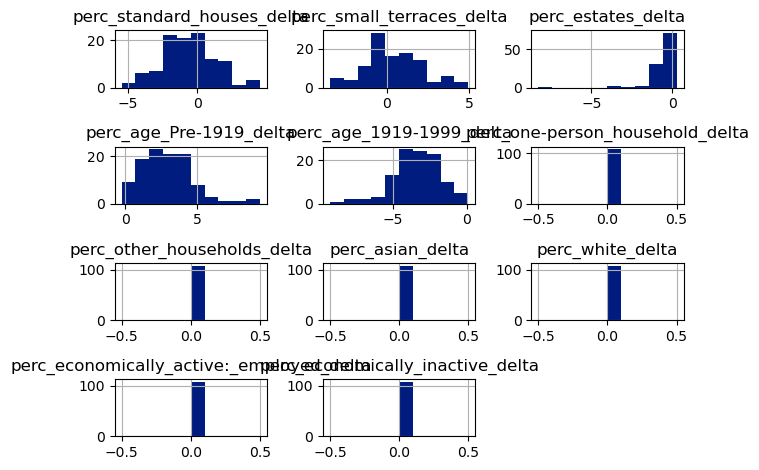

In [51]:
data[[col for col in data.columns if 'delta' in col]].hist()
plt.tight_layout()

In [45]:
pd.read_csv('/Users/gracecolverd/New_dataset/ml_scripts/v3/V66_city_clust.csv')

Unnamed: 0      TCITY15NM  perc_standard_houses  perc_small_terraces  \
0             0       Barnsley             53.102782            20.683926   
1             1       Basildon             25.549835            26.702281   
2             2    Basingstoke             41.374326            24.233010   
3             3           Bath             32.332918            32.542184   
4             4        Bedford             49.755745            23.836233   
..          ...            ...                   ...                  ...   
103         104         Woking             62.558250            15.216585   
104         105  Wolverhampton             64.888258            22.076459   
105         106      Worcester             61.458439            25.979397   
106         107       Worthing             54.056234            22.907585   
107         108           York             52.730858            34.389614   

     perc_estates  perc_age_Pre-1919  perc_age_1919-1999  \
0        0.498454          19.294822           48.523957   
1       25.209487           0.348965           80.923249   
2       17.719525           2.834951           70.539374   
3        4.021086          31.530291           50.364229   
4        3.871902          17.066867           56.217530   
..            ...                ...                 ...   
103      4.416437           6.915908           77.194980   
104      2.022511          11.061520           77.908375   
105      1.781183          17.114077           71.541662   
106      1.817786          13.683522           67.375763   
107      1.737977          19.716270           69.697075   

     perc_one-person_household  perc_asian  perc_white  \
0                    32.246640    1.303304   95.928617   
1                    28.712893    5.042705   84.523633   
2                    27.783185    8.077050   84.809923   
3                    31.730156    5.044148   88.628870   
4                    31.896687   16.740426   69.371781   
..                         ...         ...         ...   
103                  26.271837   14.791142   77.894123   
104                  30.990382   20.539142   61.952929   
105                  31.389446    5.553275   90.163371   
106                  33.965321    3.712353   91.788801   
107                  32.774036    4.475304   91.534344   

     perc_economically_active:_employed  perc_economically_inactive  
0                             46.303151                   33.200860  
1                             46.620645                   28.334523  
2                             53.161228                   24.790683  
3                             44.479511                   37.824867  
4                             47.608638                   29.635830  
..                                  ...                         ...  
103                           50.164412                   27.302706  
104                           42.534416                   32.801823  
105                           49.538779                   30.005157  
106                           47.366442                   33.733537  
107                           48.014512                   34.435923  

[108 rows x 12 columns]

array([[<AxesSubplot: title={'center': 'perc_large_houses_delta'}>,
        <AxesSubplot: title={'center': 'perc_standard_houses_delta'}>,
        <AxesSubplot: title={'center': 'perc_small_terraces_delta'}>,
        <AxesSubplot: title={'center': 'perc_estates_delta'}>],
       [<AxesSubplot: title={'center': 'perc_all_flats_delta'}>,
        <AxesSubplot: title={'center': 'perc_age_Pre-1919_delta'}>,
        <AxesSubplot: title={'center': 'perc_age_1919-1999_delta'}>,
        <AxesSubplot: title={'center': 'perc_age_Post-1999_delta'}>],
       [<AxesSubplot: title={'center': 'perc_one-person_household_delta'}>,
        <AxesSubplot: title={'center': 'perc_other_households_delta'}>,
        <AxesSubplot: title={'center': 'perc_single_family_household_delta'}>,
        <AxesSubplot: title={'center': 'perc_asian_delta'}>],
       [<AxesSubplot: title={'center': 'perc_black_delta'}>,
        <AxesSubplot: title={'center': 'perc_mixed_delta'}>,
        <AxesSubplot: title={'center': 'perc

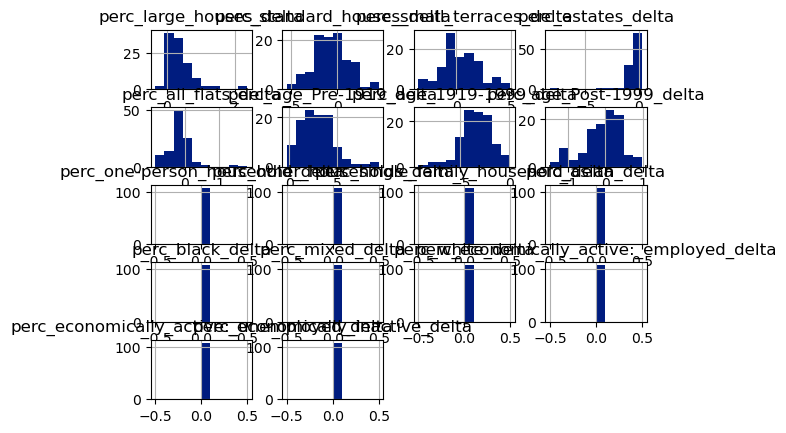

In [44]:
data[[col for col in data if 'delta' in col]].hist()

In [ ]:
# final  setting 
# now using full data   (old version with old names )
res_eth = resv3.copy() 
folder = 'v3'
res_eth.drop(columns=[ 'perc_mixed','perc_age_Post-1999', 'perc_all_flats', 'perc_black', 'perc_single_family_household', 'perc_large_houses', 'perc_economically_active:_unemployed' ]).to_csv(f'{folder}/V66_city_clust.csv')

In [8]:
import pandas as pd 

res = pd.read_csv('city_data_forclusering.csv' )
X = res.drop(columns='TCITY15NM')

labels = pd.read_csv('/Volumes/T9/Data_downloads/new-data-outputs/ml_results/city_spectral_clustering_10/labels.csv')
city_cluster = pd.concat([res, labels], axis=1)


FileNotFoundError: [Errno 2] No such file or directory: 'city_data_forclusering.csv'

In [20]:
city_cluster.head()

TCITY15NM  Medium height flats 5-6 storeys  Small low terraces  \
0     Barnsley                         0.000020            0.191706   
1     Basildon                         0.000370            0.056817   
2  Basingstoke                         0.000290            0.125647   
3         Bath                         0.001035            0.214424   
4      Bedford                         0.000215            0.187472   

   3-4 storey and smaller flats  Tall terraces 3-4 storeys  \
0                      0.015538                   0.007661   
1                      0.056491                   0.021056   
2                      0.017787                   0.004218   
3                      0.025101                   0.073765   
4                      0.024483                   0.005336   

   Large semi detached  Standard size detached  Standard size semi detached  \
0             0.000766                0.166739                     0.363317   
1             0.000152                0.138454                     0.118028   
2             0.000736                0.236810                     0.175661   
3             0.045666                0.136731                     0.187147   
4             0.000751                0.208442                     0.288756   

   2 storeys terraces with t rear extension  Semi type house in multiples  \
0                                  0.002986                      0.014694   
1                                  0.000000                      0.208148   
2                                  0.018010                      0.097505   
3                                  0.099345                      0.011357   
4                                  0.049234                      0.000483   

   Tall flats 6-15 storeys  Large detached  Very tall point block flats  \
0                 0.000177        0.002082                     0.000000   
1                 0.000044        0.002871                     0.000022   
2                 0.000134        0.005044                     0.000000   
3                 0.000027        0.021360                     0.000000   
4                 0.000054        0.003459                     0.000000   

   Very large detached  Planned balanced mixed estates  \
0              0.00002                        0.000000   
1              0.00000                        0.000000   
2              0.00000                        0.000000   
3              0.00000                        0.000318   
4              0.00000                        0.001394   

   Linked and step linked premises  Domestic outbuilding  city_total_builds  \
0                         0.004911              0.227773            55614.0   
1                         0.253502              0.127730            48883.0   
2                         0.179722              0.135467            46754.0   
3                         0.039961              0.136413            41213.0   
4                         0.038642              0.187311            39892.0   

    entropy  Cluster  
0  3.627009        5  
1  3.592350        0  
2  3.556465        2  
3  3.694562        0  
4  3.656284        5

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


n = 10 
threshold = 0.99

def run_cluster( n, wrk , city='city', folder='cclust_london', typ ='old', plotting_col='None'):
    city_cluster = load_clusters(n, city, folder, typ)
    plot_cluster_vis(city_cluster, n, wrk , plotting_col)




def load_clusters(n, city , folder, typ):
    if typ == 'old':
        path = f'/Volumes/T9/Data_downloads/new-data-outputs/ml_results/{folder}/{city}_spectral_clustering_{n}/labels.csv'
    else:
        path = f'/Volumes/T9/Data_downloads/new-data-outputs/ml_results/{folder}/{city}_city_clust_clusters_{n}/{city}_spectral_clustering_{n}/labels.csv'
    res = pd.read_csv(f'/Users/gracecolverd/New_dataset/ml_scripts/{folder}/{city}_city_clust.csv' )
    labels = pd.read_csv(path)
    if len(res)!= len(labels):
        print('err')
        # raise Exception(mismatch in data)
    city_cluster = pd.concat([res, labels], axis=1)
    return city_cluster 

def plot_cluster_vis(city_cluster, n, wrk,plotting_col ):
    df = wrk.copy() 
    # df = wrk[wrk['perc_diff_meters']<=threshold ].copy() 
    df=df[df['percent_residential']==1]
    print('Len on inut data is ', len(df))
    # ratio_city = city_counts_pc.merge(df.groupby('TCITY15NM').count().reset_index()[['TCITY15NM', 'postcode']], on='TCITY15NM')
    # ratio_city['perc_used'] = ratio_city['postcode_y'] / ratio_city['postcode_x']

    # get labels
    df = df.merge(city_cluster, on='TCITY15NM')
    # Merge ratio_city DataFrame to get the ratio values
    # df = df.merge(ratio_city, on='TCITY15NM', how='left')

    # Generate the box plots
    plot_boxplot_cities(df , n, plotting_col )
    # plot_clusters(city_cluster )
            
# Function to plot box plots for 'av_eui_h' column for multiple cities within each entropy quartile
def plot_boxplot_cities(df, n , plotting_col):
    # plotting_col = 'mean_av_gas'
    # fig, axes = plt.subplots(ncols=2, nrows=round((n+0.1)/2), figsize=(20, 3 * n ))
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(25, 13 ))
    axes = axes.ravel()
    fig.subplots_adjust(top=0.95)  
    fig.suptitle(f'Postcode EUI by City, Spectral Cluster n={n}', fontsize=15)
    for i, (quartile, dd) in enumerate(df.groupby('Cluster')):
        # Calculate the median 'av_eui_h' for each city within the quartile
        medians = dd.groupby('TCITY15NM')[plotting_col].median().reset_index()
        medians = medians.sort_values(by=plotting_col)

        # Sort the DataFrame by the medians
        dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
        dd = dd.sort_values('TCITY15NM')

        # Calculate the quartile median for the quartile
        quartile_median = dd[plotting_col].median()
        quartile_mean = dd[plotting_col].mean()
        # add mean as text
        # axes[i].text(0, 450 , f'Cluster mean: {quartile_mean:.2f}')

        # Plot the box plot
        sns.boxplot(x='TCITY15NM', y=plotting_col, data=dd, palette='viridis', ax=axes[i], showfliers=False)
        
        # Plot the quartile median as a horizontal dashed line
        axes[i].axhline(quartile_median, color='red', linestyle='--', label=f'Cluster Median: {quartile_median:.2f}')
        
        axes[i].set_title(f'Cluster {quartile}')
        axes[i].set_ylabel('Postcode EUI (kWh/m$^2$)')
        axes[i].set_xlabel('City')
        # axes[i].set_ylim(0, 300)  # Cap the y-axis at 400
        
            # Create secondary axis
        
        
        # Rotate x-axis labels and set alignment
        for label in axes[i].get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_verticalalignment('top')
            label.set_rotation_mode('anchor')
        
        # Set legend in the upper left corner
        axes[i].legend(loc='upper left')
        axes[i].yaxis.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
    plt.tight_layout() 
    plt.show()

In [7]:
enw_shp = gpd.read_file('/Volumes/T9/Data_downloads/Eng_wales_boundary_shapefiles/eng_wales_outer_shapefile/england_wales_outer_shapefile.shp')

def plot_clusters(city_cluster):
    city_cluster['Cluster'] = city_cluster['Cluster'].astype(str)
    city_shp=gpd.read_file('/Volumes/T9/Data_downloads/major_cities/Major_Towns_and_Cities_Dec_2015_Boundaries_V2_2022_-2549004559791541639 (1)/TCITY_2015_EW_BGG_V2.shp')
    f, ax = plt.subplots(figsize = (10,15))
    enw_shp.plot(ax=ax, facecolor='white', edgecolor='black',alpha=0.2)
    city_shp.merge(city_cluster, on='TCITY15NM').plot('Cluster', legend=True, ax=ax)
    plt.show() 
    



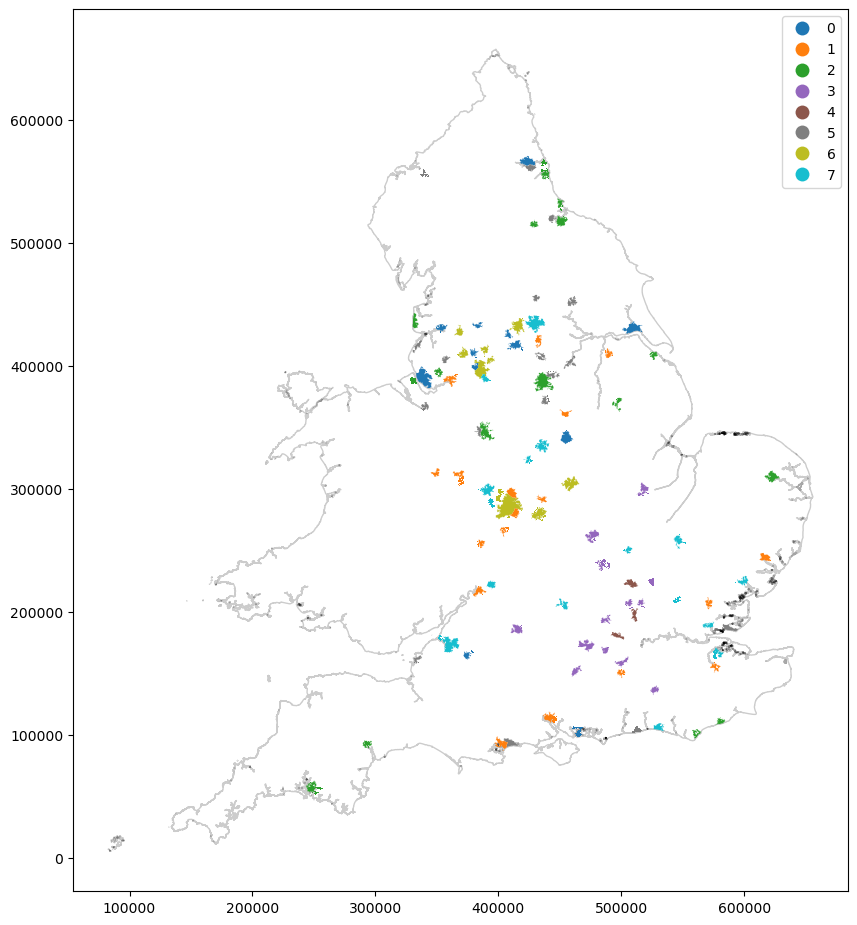

In [25]:
df = load_clusters(n, city , folder, typ='new')
plot_clusters(df)

In [169]:
# fig = plt.figure(figsize = (20,12))


# gs1 = GridSpec(3, 3, wspace=0.25, width_ratios=[17, 17, 4])
# ax1 = fig.add_subplot(gs1[0,0])
# ax2 = fig.add_subplot(gs1[0,1])
# ax3 = fig.add_subplot(gs1[0, 2 ])

# gs2 = GridSpec(3, 3, hspace=0.15)
# ax1 = fig.add_subplot(gs2[2,2])
# ax2 = fig.add_subplot(gs2[2, 1])
# ax3 = fig.add_subplot(gs2[2, 0])


# gs2 = GridSpec(3, 2, hspace=0.15)
# ax1 = fig.add_subplot(gs2[1,0])
# ax2 = fig.add_subplot(gs2[1, 1])





# plt.show()

Len on input data is 657731


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/76196351.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/76196351.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708

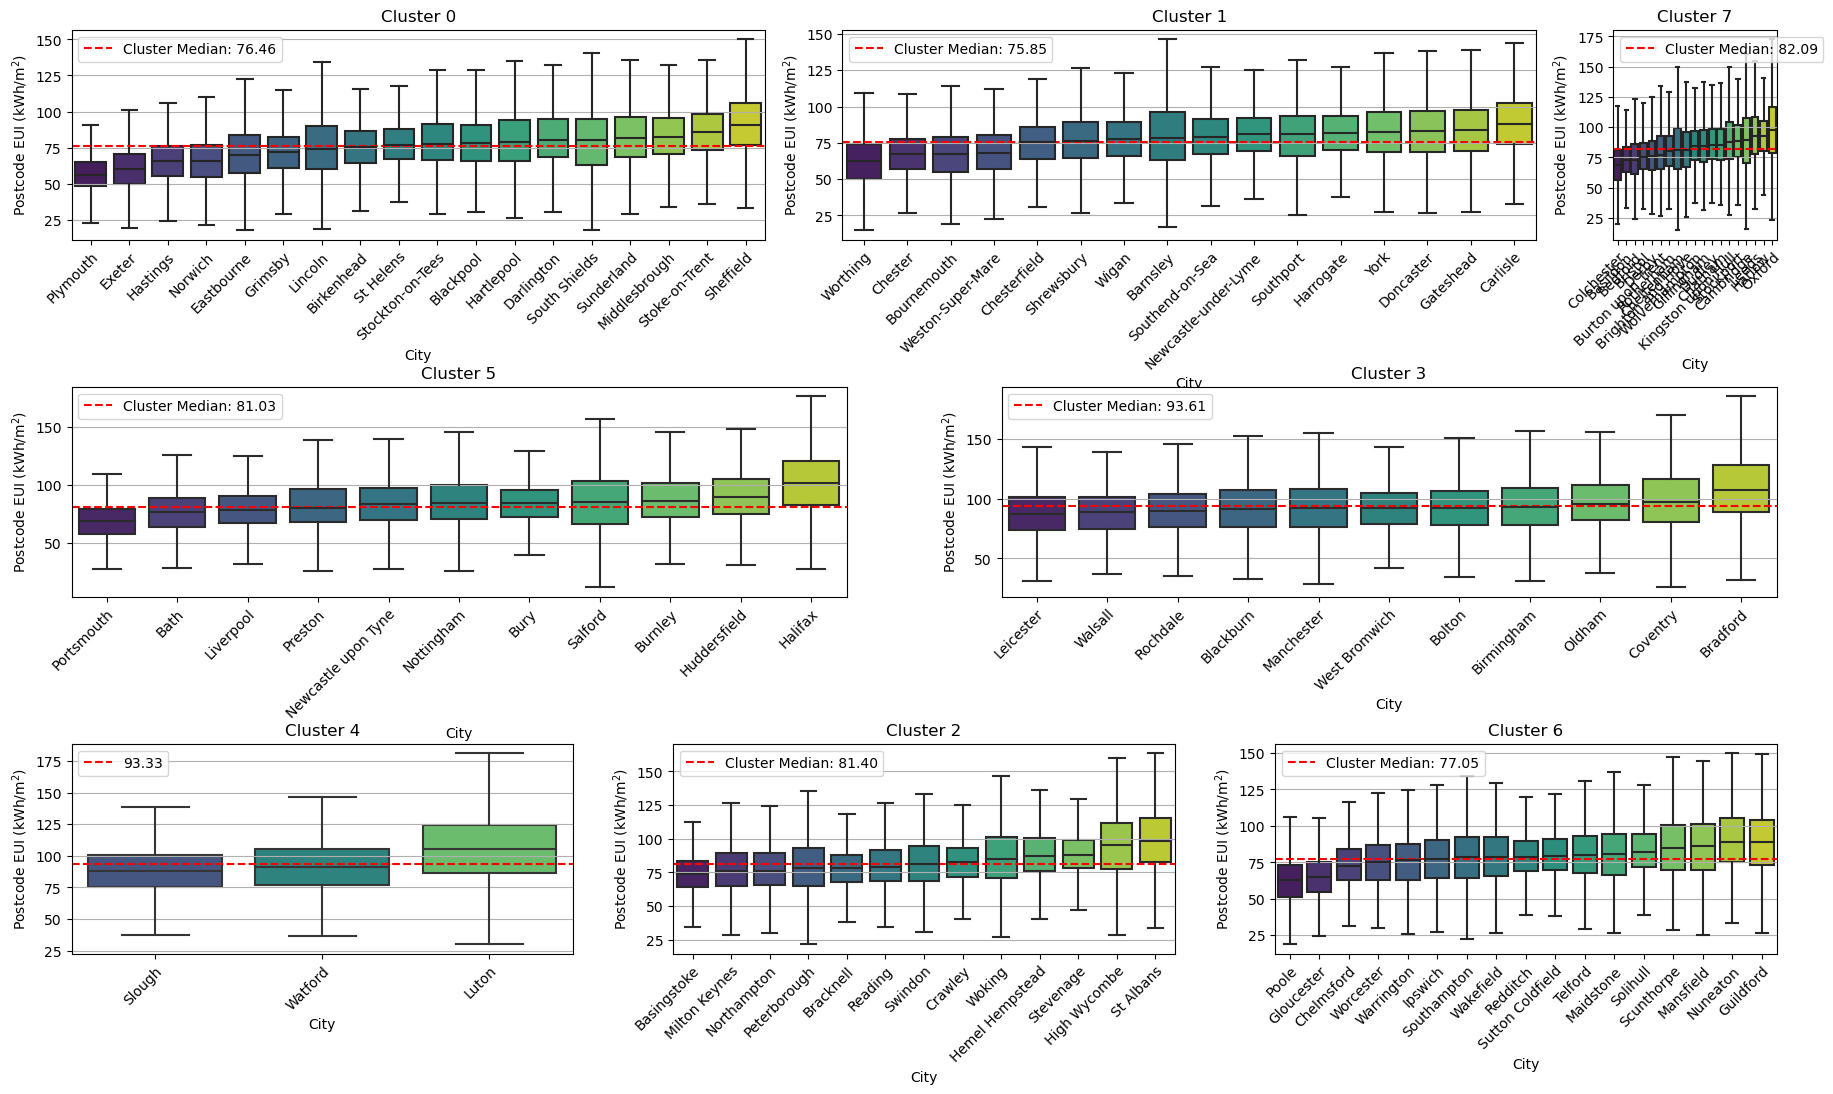

Unnamed: 0      TCITY15NM  perc_standard_houses  perc_small_terraces  \
0             0       Barnsley             53.102782            20.683926   
1             1       Basildon             25.549835            26.702281   
2             2    Basingstoke             41.374326            24.233010   
3             3           Bath             32.332918            32.542184   
4             4        Bedford             49.755745            23.836233   
..          ...            ...                   ...                  ...   
103         104         Woking             62.558250            15.216585   
104         105  Wolverhampton             64.888258            22.076459   
105         106      Worcester             61.458439            25.979397   
106         107       Worthing             54.056234            22.907585   
107         108           York             52.730858            34.389614   

     perc_estates  perc_age_Pre-1919  perc_age_1919-1999  \
0        0.498454          19.294822           48.523957   
1       25.209487           0.348965           80.923249   
2       17.719525           2.834951           70.539374   
3        4.021086          31.530291           50.364229   
4        3.871902          17.066867           56.217530   
..            ...                ...                 ...   
103      4.416437           6.915908           77.194980   
104      2.022511          11.061520           77.908375   
105      1.781183          17.114077           71.541662   
106      1.817786          13.683522           67.375763   
107      1.737977          19.716270           69.697075   

     perc_one-person_household  perc_asian  perc_white  \
0                    32.246640    1.303304   95.928617   
1                    28.712893    5.042705   84.523633   
2                    27.783185    8.077050   84.809923   
3                    31.730156    5.044148   88.628870   
4                    31.896687   16.740426   69.371781   
..                         ...         ...         ...   
103                  26.271837   14.791142   77.894123   
104                  30.990382   20.539142   61.952929   
105                  31.389446    5.553275   90.163371   
106                  33.965321    3.712353   91.788801   
107                  32.774036    4.475304   91.534344   

     perc_economically_active:_employed  perc_economically_inactive  Cluster  
0                             46.303151                   33.200860        1  
1                             46.620645                   28.334523        7  
2                             53.161228                   24.790683        2  
3                             44.479511                   37.824867        5  
4                             47.608638                   29.635830        7  
..                                  ...                         ...      ...  
103                           50.164412                   27.302706        2  
104                           42.534416                   32.801823        7  
105                           49.538779                   30.005157        6  
106                           47.366442                   33.733537        1  
107                           48.014512                   34.435923        1  

[108 rows x 13 columns]

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

n = 10
threshold = 0.99

def run_cluster(n, wrk, city='city', folder='cclust_london', typ='old', plotting_col='None'):
    city_cluster = load_clusters(n, city, folder, typ)
    plot_cluster_vis(city_cluster, n, wrk, plotting_col)
    return city_cluster

def load_clusters(n, city, folder, typ):
    if typ == 'old':
        path = f'/Volumes/T9/Data_downloads/new-data-outputs/ml_results/{folder}/{city}_spectral_clustering_{n}/labels.csv'
    else:
        path = f'/Volumes/T9/Data_downloads/new-data-outputs/ml_results/{folder}/figs/{city}_city_clust_clusters_{n}/{city}_spectral_clustering_{n}/labels.csv'
    res = pd.read_csv(f'/Users/gracecolverd/New_dataset/ml_scripts/{folder}/{city}_city_clust.csv')
    labels = pd.read_csv(path)
    if len(res) != len(labels):
        print('err')
        # raise Exception(mismatch in data)
    city_cluster = pd.concat([res, labels], axis=1)
    return city_cluster

def plot_cluster_vis(city_cluster, n, wrk, plotting_col):
    df = wrk.copy()
    df = df[df['percent_residential'] == 1]
    print('Len on input data is', len(df))

    df = df.merge(city_cluster, on='TCITY15NM')

    plot_boxplot_cities(df, n, plotting_col)

def plot_boxplot_cities(df, n, plotting_col):
    fig = plt.figure(figsize=(22, 12))
    # fig.suptitle(f'Postcode EUI by City, Spectral Cluster n={n}', fontsize=15)

    # Define GridSpec with specific width ratios for the first row
    gs1 = GridSpec(3, 3, figure=fig, hspace=0.7, wspace=0.15, width_ratios=[17, 17, 4])
    gs2 = GridSpec(3, 3, figure=fig, hspace=0.7)
    gs3 = GridSpec(3, 2, figure=fig, hspace=0.7)

    # Define the positions of the subplots
    positions = [
        (gs1[0, 0]),  # First row, first subplot (wider)
        (gs1[0, 1]),  # First row, second subplot (wider)
        (gs1[0, 2]),  # First row, third subplot (narrower)
        (gs3[1, 0]),  # Second row, first subplot (equal width)
        (gs3[1, 1]),  # Second row, second subplot (equal width)
        (gs2[2, 0]),  # Third row, first subplot
        (gs2[2, 1]),  # Third row, second subplot
        (gs2[2, 2]),  # Third row, third subplot
    ]

    # Define the desired order of clusters
    # cluster_order = [2, 5, 4, 1, 7, 0, 3, 6]
    cluster_order = [0,1,7,5,3,4,2,6,7]

    for i, quartile in enumerate(cluster_order):
  
        if i >= len(positions):
            break

        dd = df[df['Cluster'] == quartile]

        medians = dd.groupby('TCITY15NM')[plotting_col].median().reset_index()
        medians = medians.sort_values(by=plotting_col)

        dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
        dd = dd.sort_values('TCITY15NM')

        quartile_median = dd[plotting_col].median()
        quartile_mean = dd[plotting_col].mean()

        # Create subplot at the defined position
        ax = fig.add_subplot(positions[i])

        sns.boxplot(x='TCITY15NM', y=plotting_col, data=dd, palette='viridis', ax=ax, showfliers=False)

        if quartile ==4:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'{quartile_median:.2f}')
        else:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'Cluster Median: {quartile_median:.2f}')

        ax.set_title(f'Cluster {quartile}')
        ax.set_ylabel('Postcode EUI (kWh/m$^2$)')
        ax.set_xlabel('City')

        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_verticalalignment('top')
            label.set_rotation_mode('anchor')

        ax.legend(loc='upper left')
        ax.yaxis.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage:
wrkv0['mean_av_gas'] = (wrkv0['min_gas_per_vol'] + wrkv0['max_gas_per_vol']) /2 
n= 8
city = 'V66'
folder = 'v3'
run_cluster( n, wrkv0 , city, folder, typ ='new', plotting_col = 'mean_av_gas')

In [80]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import math

# def plot_boxplot_cities(df, n, plotting_col):
#     # Calculate the number of rows needed
#     num_rows = math.ceil(n / 2)
    
#     # Create a figure with 2 columns and calculated number of rows
#     fig, axes = plt.subplots(num_rows, 2, figsize=(20, 10 * num_rows))
    
#     # Flatten the axes array for easy indexing
#     axes = axes.flatten()

#     for i in range(n):
#         dd = df[df['Cluster'] == i]

#         medians = dd.groupby('TCITY15NM')[plotting_col].median().reset_index()
#         medians = medians.sort_values(by=plotting_col)

#         dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
#         dd = dd.sort_values('TCITY15NM')

#         quartile_median = dd[plotting_col].median()

#         # Create subplot
#         ax = axes[i]

#         sns.boxplot(x='TCITY15NM', y=plotting_col, data=dd, palette='viridis', ax=ax, showfliers=False)

#         ax.axhline(quartile_median, color='red', linestyle='--', label=f'Cluster Median: {quartile_median:.2f}')

#         ax.set_title(f'Cluster {i}')
#         ax.set_ylabel('Postcode EUI (kWh/m$^2$)')
#         ax.set_xlabel('City')

#         for label in ax.get_xticklabels():
#             label.set_rotation(45)
#             label.set_horizontalalignment('right')
#             label.set_verticalalignment('top')
#             label.set_rotation_mode('anchor')

#         ax.legend(loc='upper left')
#         ax.yaxis.grid(True)

#     # Remove any unused subplots
#     for j in range(n, len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()
#     plt.show()

# # Example usage:
# wrkv0['mean_av_gas'] = (wrkv0['min_gas_per_vol'] + wrkv0['max_gas_per_vol']) / 2 
# n = 12
# city = 'V66'
# folder = 'v3'
# cdf = run_cluster(n, wrkv0, city, folder, typ='new', plotting_col='mean_av_gas')
# plot_boxplot_cities(cdf, n, 'mean_av_gas')

In [19]:
wrkv0.columns.tolist() 

['postcode',
 'all_types_total_buildings',
 'all_types_uprn_count_total',
 'comm_alltypes_count',
 'unknown_alltypes',
 'all_res_total_buildings',
 'all_res_premise_area_total',
 'all_res_gross_area_total',
 'all_res_heated_vol_fc_total',
 'all_res_heated_vol_h_total',
 'all_res_base_floor_total',
 'all_res_basement_heated_vol_max_total',
 'all_res_listed_bool_total',
 'all_res_uprn_count_total',
 'clean_res_total_buildings',
 'clean_res_premise_area_total',
 'clean_res_gross_area_total',
 'clean_res_heated_vol_fc_total',
 'clean_res_heated_vol_h_total',
 'clean_res_base_floor_total',
 'clean_res_basement_heated_vol_max_total',
 'clean_res_listed_bool_total',
 'clean_res_uprn_count_total',
 'outb_res_total_buildings',
 'outb_res_premise_area_total',
 'outb_res_gross_area_total',
 'outb_res_heated_vol_fc_total',
 'outb_res_heated_vol_h_total',
 'outb_res_base_floor_total',
 'outb_res_basement_heated_vol_max_total',
 'outb_res_listed_bool_total',
 'outb_res_uprn_count_total',
 'mixed_tot

Len on input data is 621415


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/3050669469.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/3050669469.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_3

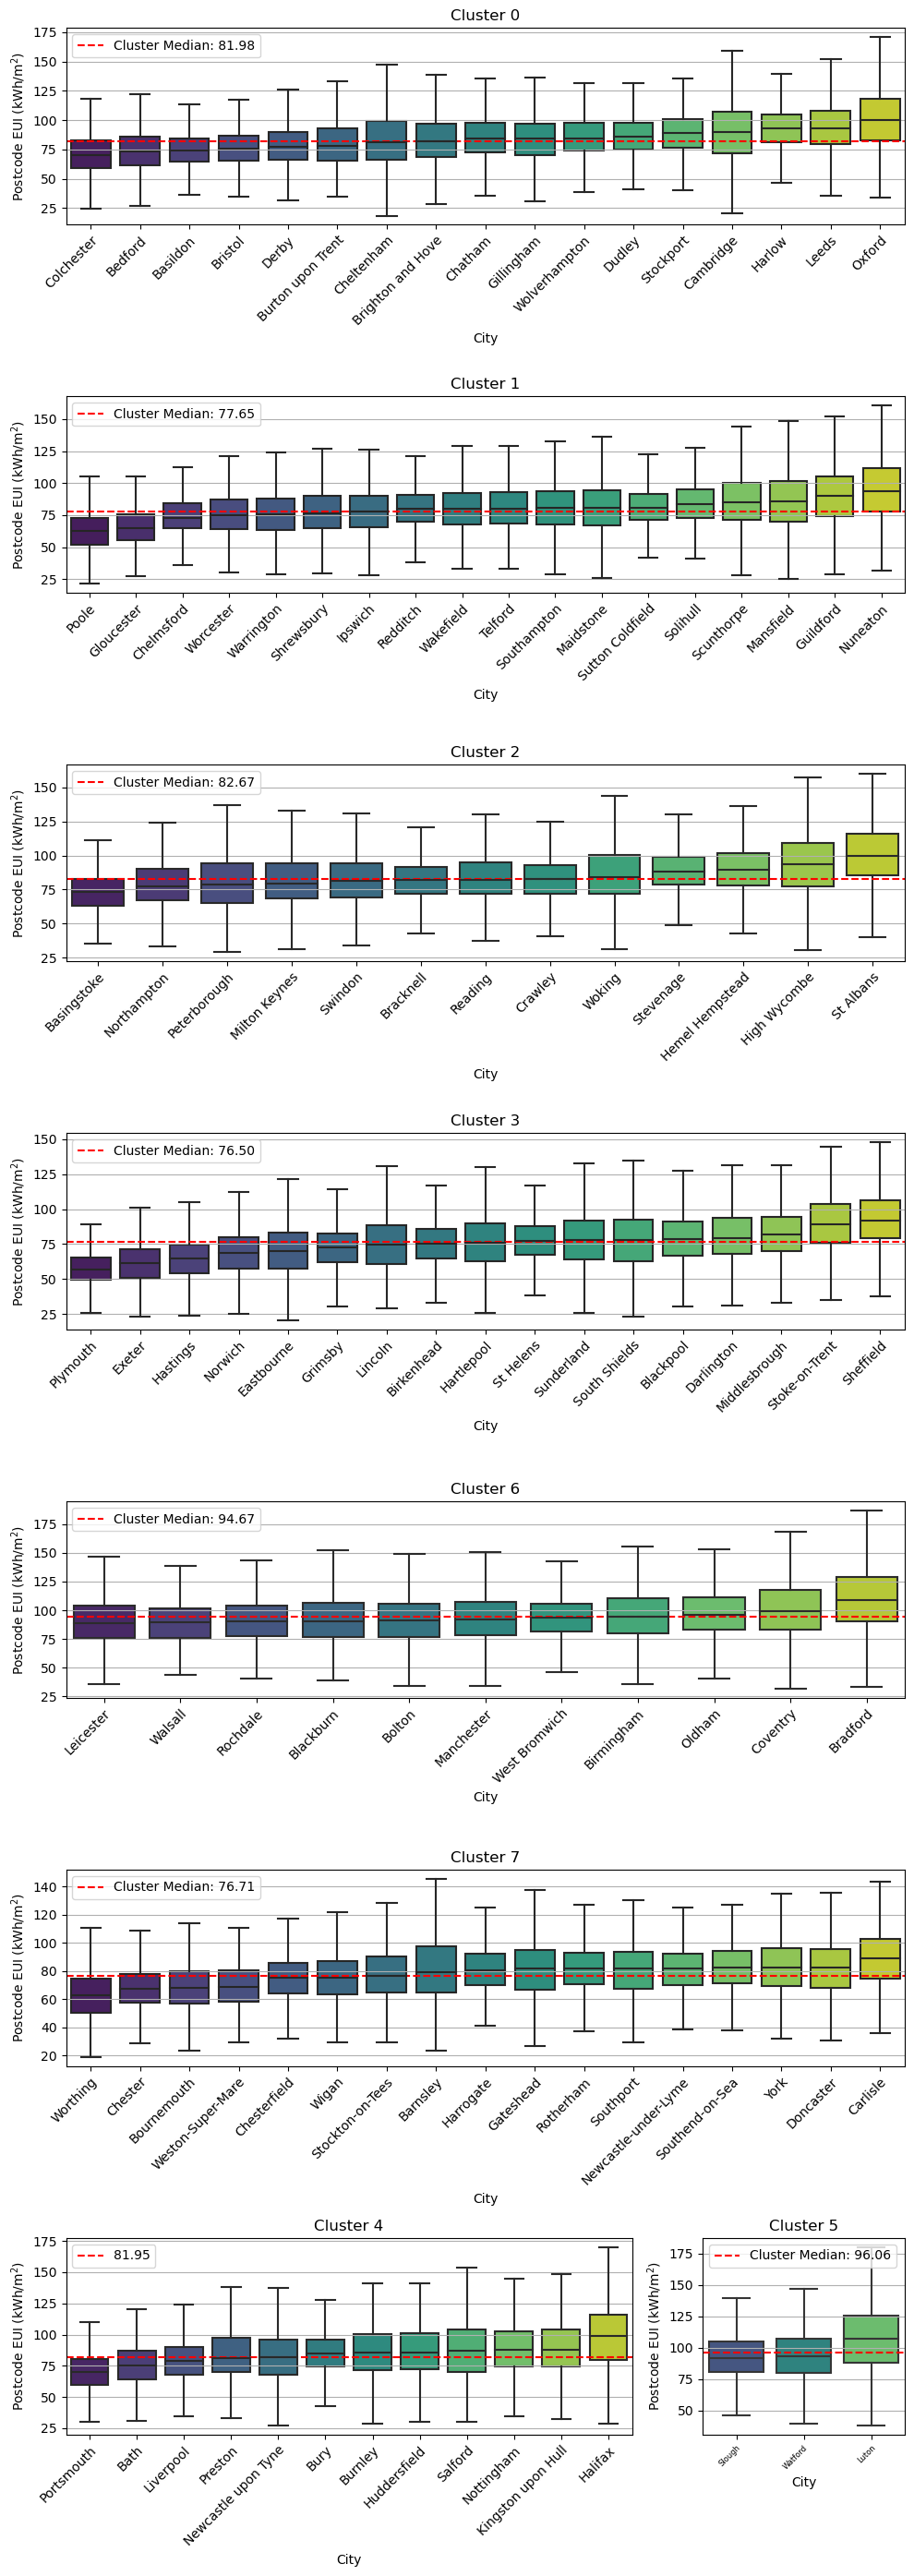

In [68]:
def plot_boxplot_cities(df, n, plotting_col):
    fig = plt.figure(figsize=(10, 28))  # Adjusted figure size

    # Define GridSpec for the layout
    gs = GridSpec(7, 10, figure=fig, height_ratios=[1, 1, 1, 1, 1, 1, 1])

    # Define the desired order of clusters
    cluster_order = [0, 1,2,3,6,7,4 , 5]

    for i, quartile in enumerate(cluster_order):
        dd = df[df['Cluster'] == quartile]

        medians = dd.groupby('TCITY15NM')[plotting_col].median().reset_index()
        medians = medians.sort_values(by=plotting_col)

        dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
        dd = dd.sort_values('TCITY15NM')

        quartile_median = dd[plotting_col].median()

        # Create subplot
        if i < 6:
            ax = fig.add_subplot(gs[i, :])
        elif i == 6:
            ax = fig.add_subplot(gs[6, :7])  # 70% width
        else:
            ax = fig.add_subplot(gs[6, 7:])  # 30% width

        sns.boxplot(x='TCITY15NM', y=plotting_col, data=dd, palette='viridis', ax=ax, showfliers=False)

        if quartile == 4:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'{quartile_median:.2f}')
        else:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'Cluster Median: {quartile_median:.2f}')

        ax.set_title(f'Cluster {quartile}')
        ax.set_ylabel('Postcode EUI (kWh/m$^2$)')
        ax.set_xlabel('City')

        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_verticalalignment('top')
            label.set_rotation_mode('anchor')

        ax.legend(loc='upper left')
        ax.yaxis.grid(True)

        # Adjust x-axis labels for the smaller plot
        if i == 7:  # For the last (smaller) plot
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)

    plt.tight_layout()
    plt.show()

    
wrkv1['eui'] = wrkv1['total_gas'] / wrkv1['clean_res_heated_vol_h_total']
n= 8
city = 'V66'
folder = 'final_v2'

def run_cluster( n, wrk , city='city', folder='cclust_london', typ ='old', plotting_col='None'):
    city_cluster = load_clusters(n, city, folder, typ)
    plot_cluster_vis(city_cluster, n, wrk , plotting_col)


def load_clusters(n, city , folder, typ):

    path = f'/Volumes/T9/Data_downloads/new-data-outputs/ml_results/{folder}_seed0/{city}_city_clust_clusters_{n}/{city}_spectral_clustering_{n}/labels.csv'
    res = pd.read_csv(f'/Users/gracecolverd/New_dataset/ml_scripts/{folder}/{city}_city_clust.csv' )
    labels = pd.read_csv(path)
    if len(res)!= len(labels):
        print('err')
        # raise Exception(mismatch in data)
    city_cluster = pd.concat([res, labels], axis=1)
    return city_cluster 

cdf = run_cluster( n, wrkv1 , city, folder, typ ='new', plotting_col = 'eui')

In [88]:
cc = load_clusters(n, city , folder, '') 
cc.drop(columns=['Unnamed: 0'],inplace=True )
coun = cc.groupby('Cluster').count()['perc_standard_houses'] 


pd.concat([cc.groupby('Cluster').mean().reset_index() ,coun], axis=1).round(1).to_csv('clust_summ.csv')

/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/3659815758.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pd.concat([cc.groupby('Cluster').mean().reset_index() ,coun], axis=1).round(1).to_csv('clust_summ.csv')


In [95]:
count_df = cc.groupby('Cluster').count()[['perc_standard_houses'] ].reset_index().rename(columns={'perc_standard_houses':'count'})

In [99]:
cc.groupby('Cluster').mean().reset_index().merge(count_df,  on ='Cluster').round(1)

/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/2987512714.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cc.groupby('Cluster').mean().reset_index().merge(count_df,  on ='Cluster').round(1)


Cluster  perc_standard_houses  perc_small_terraces  perc_estates  \
0        0                  44.1                 32.2           6.0   
1        1                  61.3                 20.7           3.3   
2        2                  47.3                 29.3           8.0   
3        3                  45.2                 32.6           2.6   
4        4                  37.4                 40.8           3.7   
5        5                  45.1                 30.3           3.9   
6        6                  42.1                 40.1           3.4   
7        7                  56.1                 22.1           3.0   

   perc_age_Pre-1919  perc_age_1919-1999  perc_one-person_household  \
0               18.1                65.1                       30.8   
1               11.5                71.2                       30.0   
2                8.5                73.9                       27.4   
3               20.1                60.6                       34.7   
4               26.9                56.9                       33.6   
5               10.7                70.4                       25.5   
6               23.6                60.5                       29.8   
7               17.5                64.0                       33.9   

   perc_asian  perc_white  perc_economically_active:_employed  \
0        10.3        79.1                                47.1   
1         6.9        87.3                                47.8   
2        12.3        77.4                                50.4   
3         4.2        91.3                                43.4   
4        12.0        79.1                                43.4   
5        33.8        50.6                                47.0   
6        33.5        53.3                                40.0   
7         3.8        91.9                                46.0   

   perc_economically_inactive  count  
0                        30.7     17  
1                        31.2     18  
2                        26.3     13  
3                        35.5     17  
4                        34.3     12  
5                        26.6      3  
6                        33.5     11  
7                        33.9     17

In [103]:
cc[['Cluster', 'TCITY15NM' ]].drop_duplicates()


Cluster      TCITY15NM
0          7       Barnsley
1          0       Basildon
2          2    Basingstoke
3          4           Bath
4          0        Bedford
..       ...            ...
103        2         Woking
104        0  Wolverhampton
105        1      Worcester
106        7       Worthing
107        7           York

[108 rows x 2 columns]

In [108]:
import pandas as pd

# Assuming your dataframe is called 'cc'
df = cc[['Cluster', 'TCITY15NM']].drop_duplicates()

# Group by Cluster and aggregate city names into lists
result = df.groupby('Cluster')['TCITY15NM'].agg(list).sort_index()

# Print each cluster and its members
for cluster, cities in result.items():
    print(f"Cluster {cluster}:")
    for city in cities:
        print(f"  - {city}")
    print()  # Add an empty line between clusters for readability

# If you want to store this information in a dataframe for further use:
result_df = result.to_frame(name='Cities')
print(result_df)

Cluster 0:
  - Basildon
  - Bedford
  - Brighton and Hove
  - Bristol
  - Burton upon Trent
  - Cambridge
  - Chatham
  - Cheltenham
  - Colchester
  - Derby
  - Dudley
  - Gillingham
  - Harlow
  - Leeds
  - Oxford
  - Stockport
  - Wolverhampton

Cluster 1:
  - Chelmsford
  - Gloucester
  - Guildford
  - Ipswich
  - Maidstone
  - Mansfield
  - Nuneaton
  - Poole
  - Redditch
  - Scunthorpe
  - Shrewsbury
  - Solihull
  - Southampton
  - Sutton Coldfield
  - Telford
  - Wakefield
  - Warrington
  - Worcester

Cluster 2:
  - Basingstoke
  - Bracknell
  - Crawley
  - Hemel Hempstead
  - High Wycombe
  - Milton Keynes
  - Northampton
  - Peterborough
  - Reading
  - St Albans
  - Stevenage
  - Swindon
  - Woking

Cluster 3:
  - Birkenhead
  - Blackpool
  - Darlington
  - Eastbourne
  - Exeter
  - Grimsby
  - Hartlepool
  - Hastings
  - Lincoln
  - Middlesbrough
  - Norwich
  - Plymouth
  - Sheffield
  - South Shields
  - St Helens
  - Stoke-on-Trent
  - Sunderland

Cluster 4:
  - Bath
  

Len on input data is 657731


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/1527188869.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/1527188869.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_3

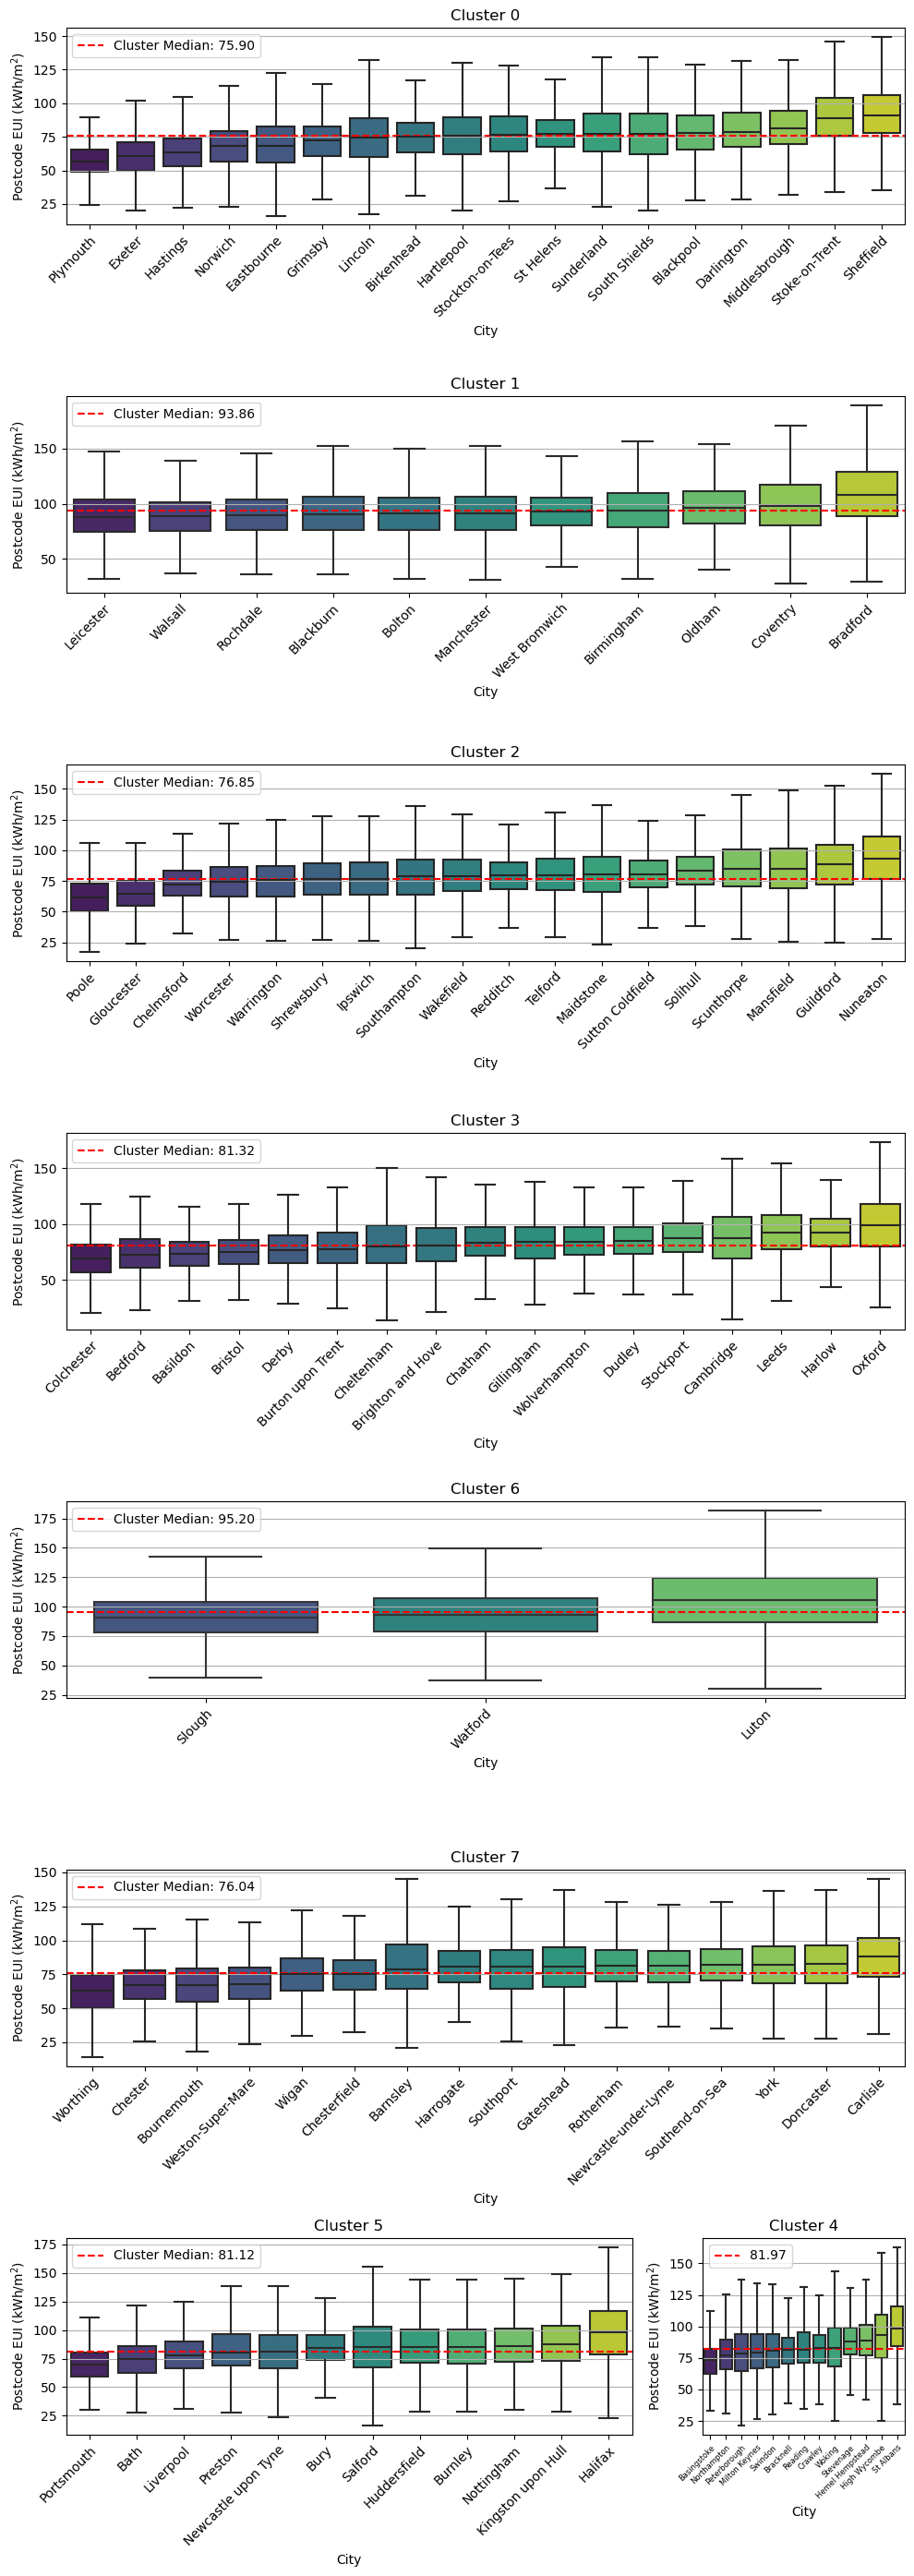

In [63]:
def plot_boxplot_cities(df, n, plotting_col):
    fig = plt.figure(figsize=(10, 28))  # Adjusted figure size

    # Define GridSpec for the layout
    gs = GridSpec(7, 10, figure=fig, height_ratios=[1, 1, 1, 1, 1, 1, 1])

    # Define the desired order of clusters
    cluster_order = [0, 1,2,3,6,7,5,4 ]

    for i, quartile in enumerate(cluster_order):
        dd = df[df['Cluster'] == quartile]

        medians = dd.groupby('TCITY15NM')[plotting_col].median().reset_index()
        medians = medians.sort_values(by=plotting_col)

        dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
        dd = dd.sort_values('TCITY15NM')

        quartile_median = dd[plotting_col].median()

        # Create subplot
        if i < 6:
            ax = fig.add_subplot(gs[i, :])
        elif i == 6:
            ax = fig.add_subplot(gs[6, :7])  # 70% width
        else:
            ax = fig.add_subplot(gs[6, 7:])  # 30% width

        sns.boxplot(x='TCITY15NM', y=plotting_col, data=dd, palette='viridis', ax=ax, showfliers=False)

        if quartile == 4:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'{quartile_median:.2f}')
        else:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'Cluster Median: {quartile_median:.2f}')

        ax.set_title(f'Cluster {quartile}')
        ax.set_ylabel('Postcode EUI (kWh/m$^2$)')
        ax.set_xlabel('City')

        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_verticalalignment('top')
            label.set_rotation_mode('anchor')

        ax.legend(loc='upper left')
        ax.yaxis.grid(True)

        # Adjust x-axis labels for the smaller plot
        if i == 7:  # For the last (smaller) plot
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)

    plt.tight_layout()
    plt.show()
# Example usage:
wrkv0['mean_av_gas'] = (wrkv0['min_gas_per_vol'] + wrkv0['max_gas_per_vol']) /2 
wrkv0['eui'] = wrkv0['total_gas'] / wrkv0['clean_res_gross_area_total']
wrkv0['eui'] = wrkv0['total_gas'] / wrkv0['clean_res_heated_vol_h_total']
n= 8
city = 'V66'
folder = 'final_v2'

def run_cluster( n, wrk , city='city', folder='cclust_london', typ ='old', plotting_col='None'):
    city_cluster = load_clusters(n, city, folder, typ)
    plot_cluster_vis(city_cluster, n, wrk , plotting_col)


def load_clusters(n, city , folder, typ):

    path = f'/Volumes/T9/Data_downloads/new-data-outputs/ml_results/{folder}/{city}_city_clust_clusters_{n}/{city}_spectral_clustering_{n}/labels.csv'
    res = pd.read_csv(f'/Users/gracecolverd/New_dataset/ml_scripts/{folder}/{city}_city_clust.csv' )
    labels = pd.read_csv(path)
    if len(res)!= len(labels):
        print('err')
        # raise Exception(mismatch in data)
    city_cluster = pd.concat([res, labels], axis=1)
    return city_cluster 

cdf = run_cluster( n, wrkv0 , city, folder, typ ='new', plotting_col = 'eui')

Len on input data is 657731


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/3938166539.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/3938166539.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_3

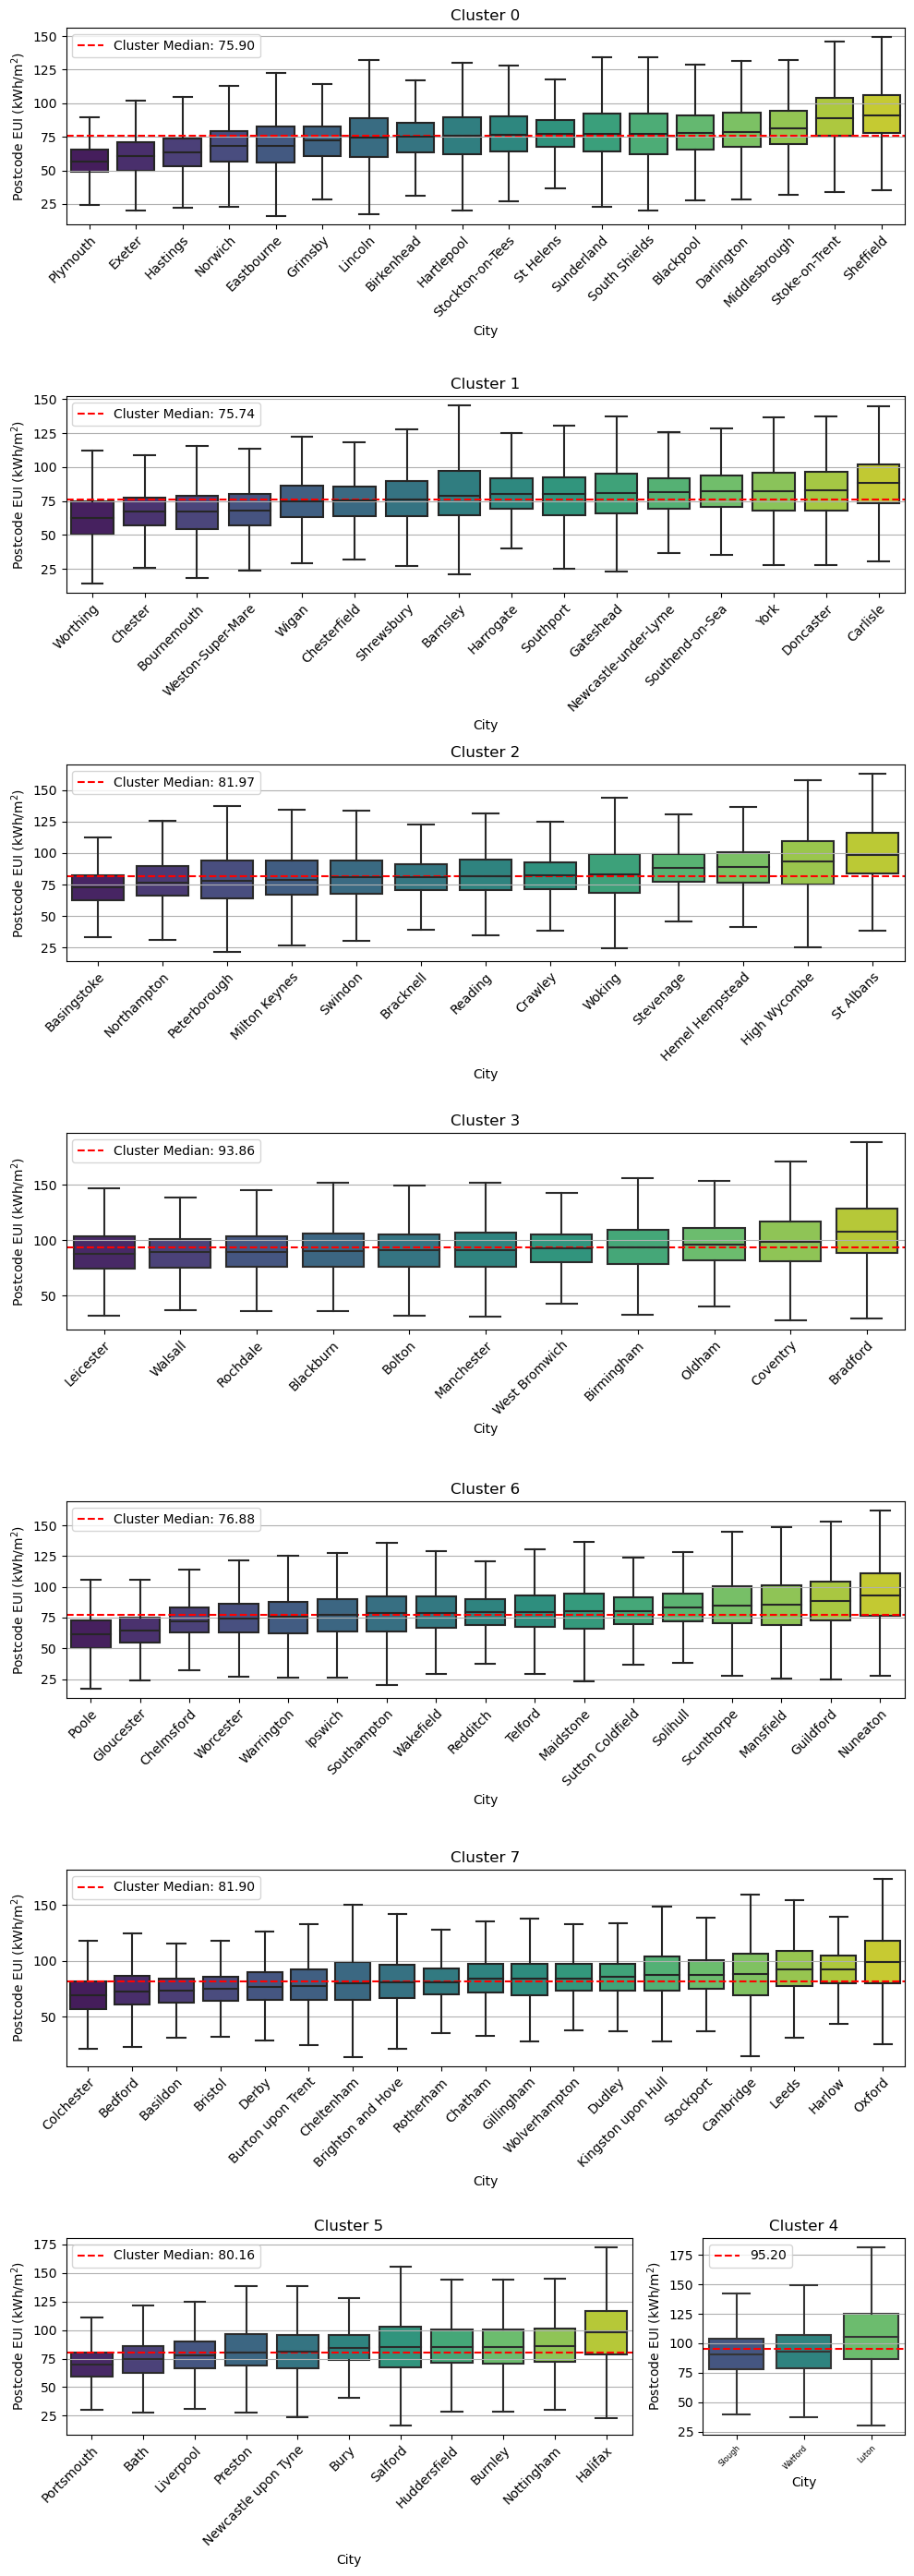

In [22]:
def plot_boxplot_cities(df, n, plotting_col):
    fig = plt.figure(figsize=(10, 28))  # Adjusted figure size

    # Define GridSpec for the layout
    gs = GridSpec(7, 10, figure=fig, height_ratios=[1, 1, 1, 1, 1, 1, 1])

    # Define the desired order of clusters
    cluster_order = [0, 1,2,3,6,7,5,4 ]

    for i, quartile in enumerate(cluster_order):
        dd = df[df['Cluster'] == quartile]

        medians = dd.groupby('TCITY15NM')[plotting_col].median().reset_index()
        medians = medians.sort_values(by=plotting_col)

        dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
        dd = dd.sort_values('TCITY15NM')

        quartile_median = dd[plotting_col].median()

        # Create subplot
        if i < 6:
            ax = fig.add_subplot(gs[i, :])
        elif i == 6:
            ax = fig.add_subplot(gs[6, :7])  # 70% width
        else:
            ax = fig.add_subplot(gs[6, 7:])  # 30% width

        sns.boxplot(x='TCITY15NM', y=plotting_col, data=dd, palette='viridis', ax=ax, showfliers=False)

        if quartile == 4:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'{quartile_median:.2f}')
        else:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'Cluster Median: {quartile_median:.2f}')

        ax.set_title(f'Cluster {quartile}')
        ax.set_ylabel('Postcode EUI (kWh/m$^2$)')
        ax.set_xlabel('City')

        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_verticalalignment('top')
            label.set_rotation_mode('anchor')

        ax.legend(loc='upper left')
        ax.yaxis.grid(True)

        # Adjust x-axis labels for the smaller plot
        if i == 7:  # For the last (smaller) plot
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)

    plt.tight_layout()
    plt.show()
# Example usage:
wrkv0['mean_av_gas'] = (wrkv0['min_gas_per_vol'] + wrkv0['max_gas_per_vol']) /2 
wrkv0['eui'] = wrkv0['total_gas'] / wrkv0['clean_res_gross_area_total']
wrkv0['eui'] = wrkv0['total_gas'] / wrkv0['clean_res_heated_vol_h_total']
n= 8
city = 'V66'
folder = 'v3'
cdf = run_cluster( n, wrkv0 , city, folder, typ ='new', plotting_col = 'eui')

Len on input data is 621415


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/63664619.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/63664619.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708

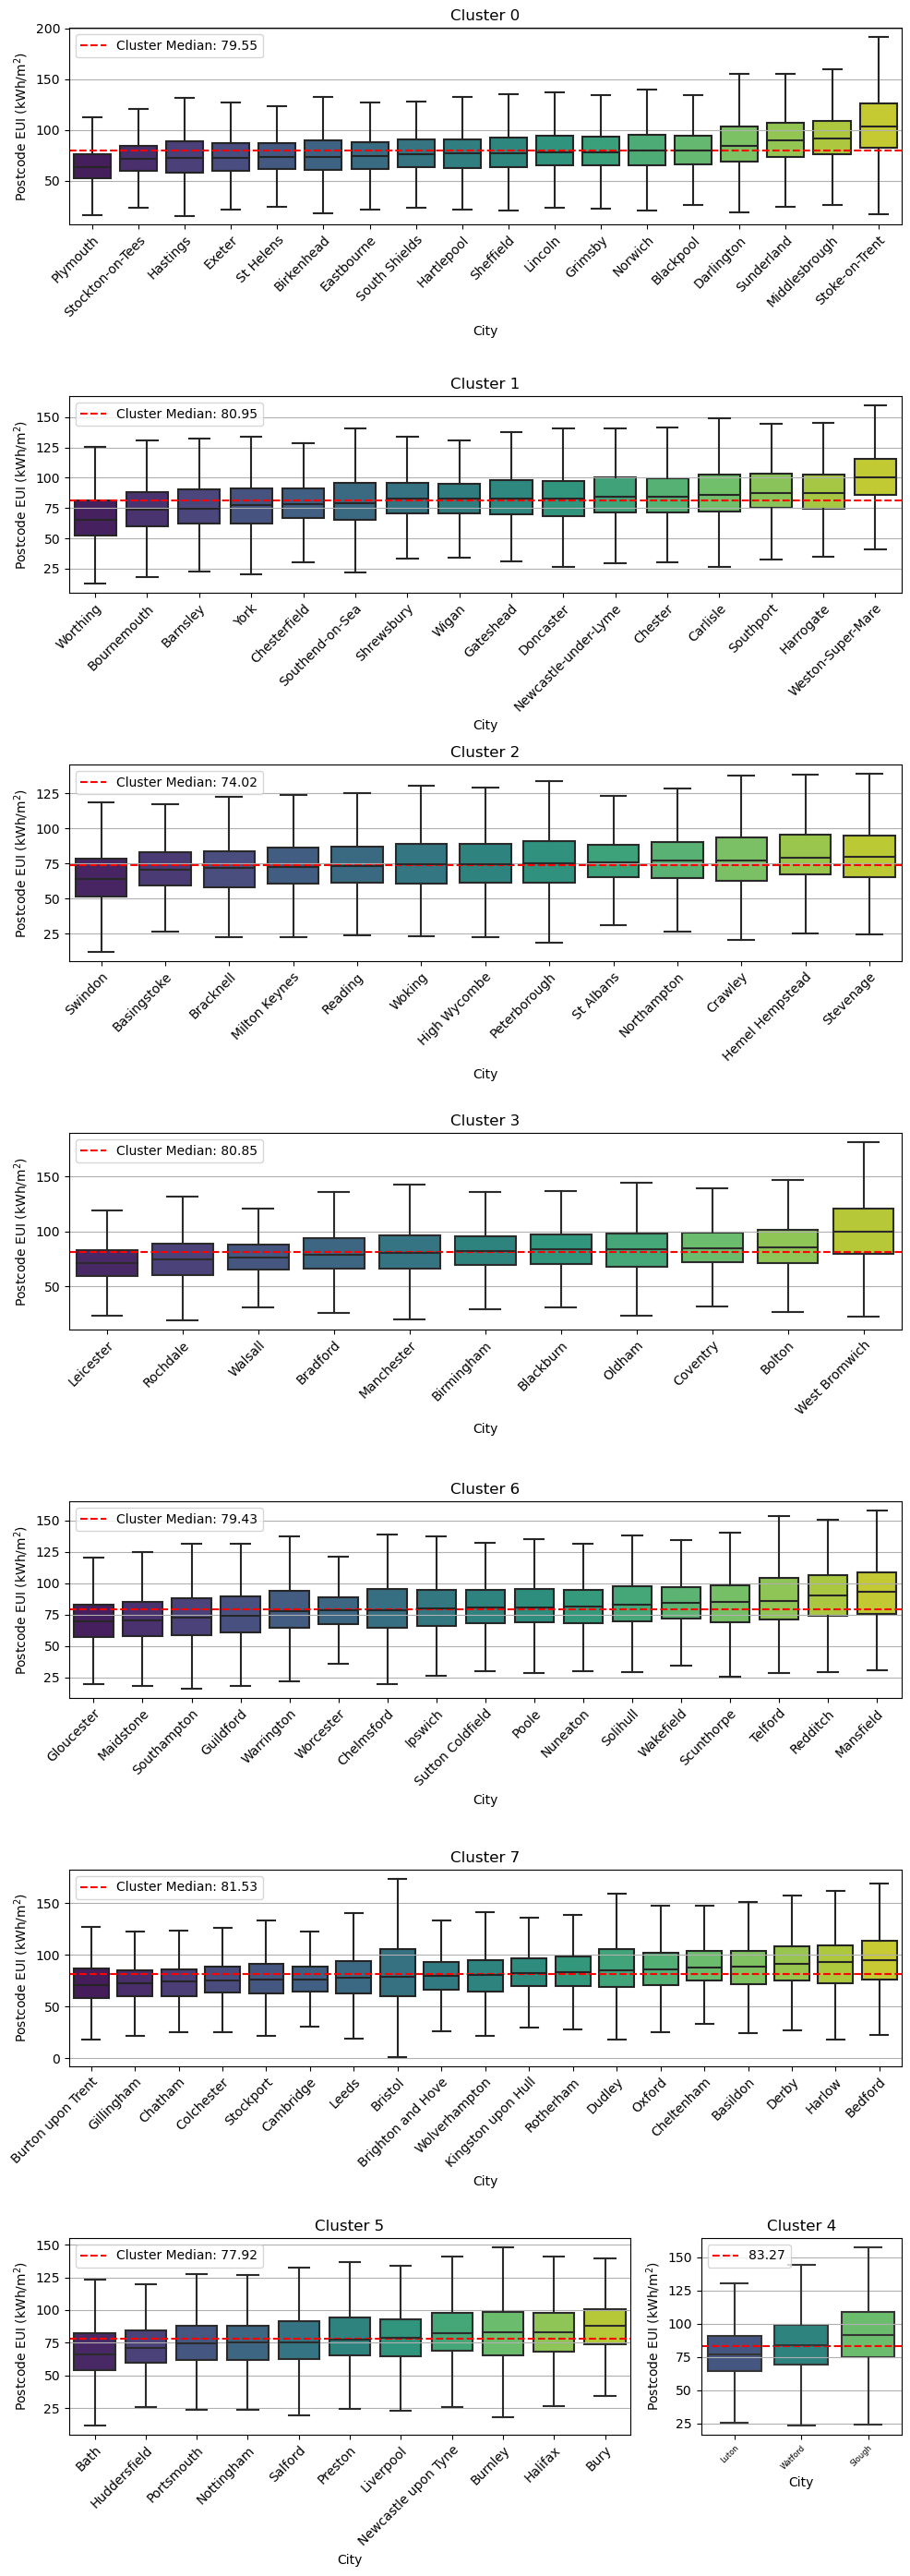

In [24]:
def plot_boxplot_cities(df, n, plotting_col):
    fig = plt.figure(figsize=(10, 28))  # Adjusted figure size

    # Define GridSpec for the layout
    gs = GridSpec(7, 10, figure=fig, height_ratios=[1, 1, 1, 1, 1, 1, 1])

    # Define the desired order of clusters
    cluster_order = [0, 1,2,3,6,7,5,4 ]

    for i, quartile in enumerate(cluster_order):
        dd = df[df['Cluster'] == quartile]

        medians = dd.groupby('TCITY15NM')[plotting_col].median().reset_index()
        medians = medians.sort_values(by=plotting_col)

        dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
        dd = dd.sort_values('TCITY15NM')

        quartile_median = dd[plotting_col].median()

        # Create subplot
        if i < 6:
            ax = fig.add_subplot(gs[i, :])
        elif i == 6:
            ax = fig.add_subplot(gs[6, :7])  # 70% width
        else:
            ax = fig.add_subplot(gs[6, 7:])  # 30% width

        sns.boxplot(x='TCITY15NM', y=plotting_col, data=dd, palette='viridis', ax=ax, showfliers=False)

        if quartile == 4:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'{quartile_median:.2f}')
        else:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'Cluster Median: {quartile_median:.2f}')

        ax.set_title(f'Cluster {quartile}')
        ax.set_ylabel('Postcode EUI (kWh/m$^2$)')
        ax.set_xlabel('City')

        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_verticalalignment('top')
            label.set_rotation_mode('anchor')

        ax.legend(loc='upper left')
        ax.yaxis.grid(True)

        # Adjust x-axis labels for the smaller plot
        if i == 7:  # For the last (smaller) plot
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)

    plt.tight_layout()
    plt.show()
# Example usage:
wrkv1['mean_av_gas'] = (wrkv0['min_gas_per_vol'] + wrkv0['max_gas_per_vol']) /2 
wrkv1['eui'] = wrkv1['total_gas'] / wrkv1['clean_res_gross_area_total']
# wrkv1['eui'] = wrkv1['total_gas'] / wrkv1['clean_res_heated_vol_h_total']
n= 8
city = 'V66'
folder = 'v3'
cdf = run_cluster( n, wrkv1 , city, folder, typ ='new', plotting_col = 'mean_av_gas')

In [25]:
wrkv1

postcode  all_types_total_buildings  all_types_uprn_count_total  \
0       PL6 7LP                       46.0                        27.0   
1       PL6 7JP                       30.0                        19.0   
2       PL6 7LD                       32.0                        23.0   
3       PL6 7JF                       92.0                        49.0   
4       PL6 7LB                       21.0                        10.0   
...         ...                        ...                         ...   
621410   N9 8RE                       26.0                        23.0   
621411   N9 8RD                        6.0                         6.0   
621412   N9 8RA                       38.0                        38.0   
621413   N9 8RH                       14.0                        17.0   
621414   N9 8RN                       55.0                        50.0   

        comm_alltypes_count  unknown_alltypes  all_res_total_buildings  \
0                       0.0               0.0                     46.0   
1                       0.0               0.0                     30.0   
2                       0.0               0.0                     32.0   
3                       0.0               0.0                     92.0   
4                       0.0               0.0                     21.0   
...                     ...               ...                      ...   
621410                  0.0               0.0                     26.0   
621411                  0.0               0.0                      6.0   
621412                  0.0               0.0                     38.0   
621413                  0.0               0.0                     14.0   
621414                  0.0               0.0                     55.0   

        all_res_premise_area_total  all_res_gross_area_total  \
0                      2730.499987               5577.799982   
1                      4689.299968               9234.699935   
2                      1742.700010               3556.100004   
3                      4795.300016               9054.000033   
4                      1606.300001               3055.400002   
...                            ...                       ...   
621410                 1213.400001               2355.100001   
621411                  303.200003                598.000006   
621412                 1888.100019               3767.100039   
621413                  731.200001               1462.400002   
621414                 2898.499998               5747.399996   

        all_res_heated_vol_fc_total  all_res_heated_vol_h_total  ...  \
0                       5577.799971                 5245.795845  ...   
1                       9189.842793                 9095.246449  ...   
2                       3556.100023                 3369.686897  ...   
3                       9032.220032                 9166.729917  ...   
4                       3030.273686                 3010.885977  ...   
...                             ...                         ...  ...   
621410                  2355.100001                 2380.918878  ...   
621411                   598.000006                  605.217270  ...   
621412                  3767.100039                 3948.243253  ...   
621413                  1462.400002                 1532.890644  ...   
621414                  5747.399996                 5817.146482  ...   

                          RUC11   LSOA11CD   LSOA21CD  TCITY15CD  TCITY15NM  \
0           Urban city and town  E01015097  E01015097  J01000072   Plymouth   
1           Urban city and town  E01015097  E01015097  J01000072   Plymouth   
2           Urban city and town  E01015097  E01015097  J01000072   Plymouth   
3           Urban city and town  E01015097  E01015097  J01000072   Plymouth   
4           Urban city and town  E01015097  E01015097  J01000072   Plymouth   
...                         ...        ...        ...        ...        ...   
621410  Urban major conurbation  E01001487

Len on input data is 621415


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/4003064928.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/4003064928.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_3

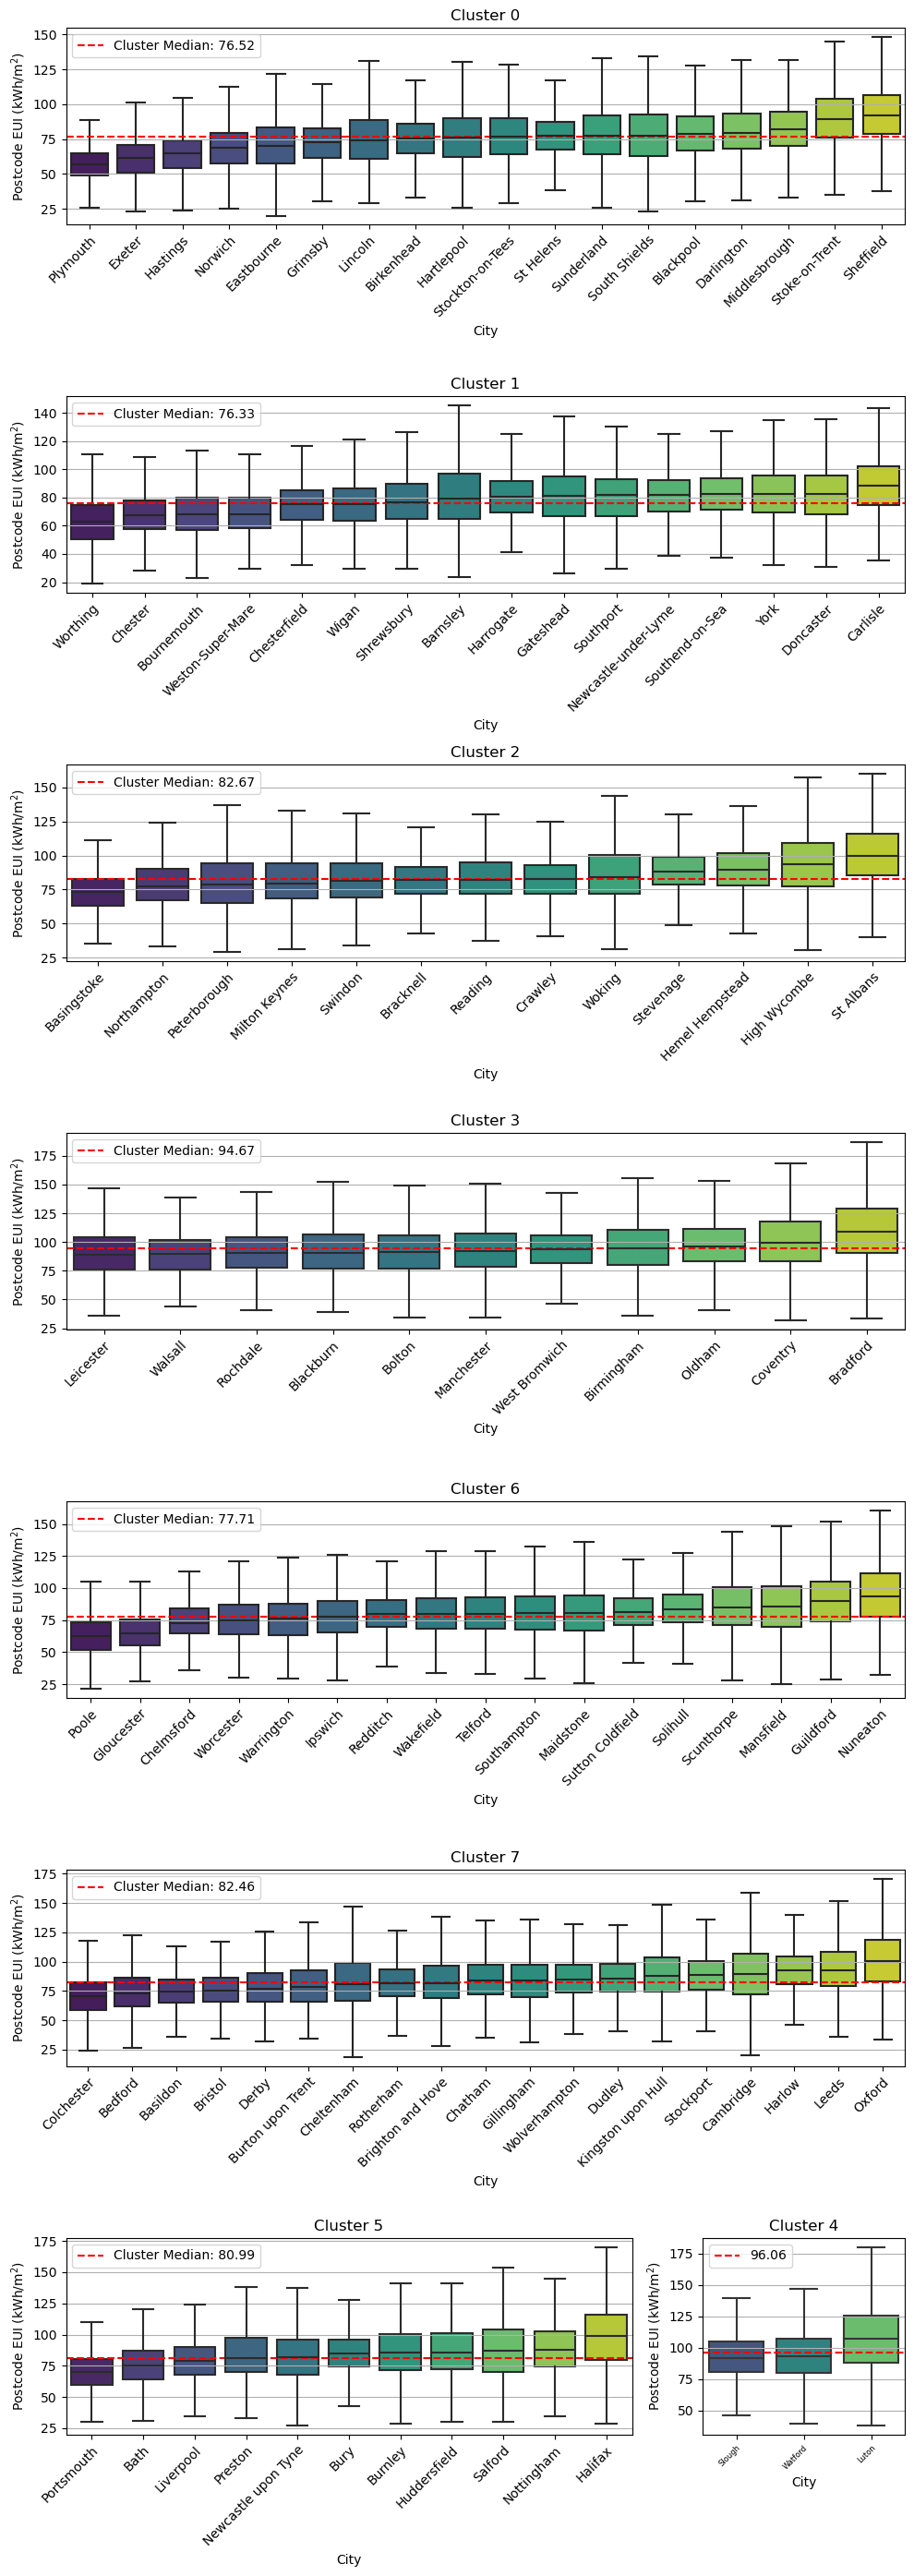

In [23]:
def plot_boxplot_cities(df, n, plotting_col):
    fig = plt.figure(figsize=(10, 28))  # Adjusted figure size

    # Define GridSpec for the layout
    gs = GridSpec(7, 10, figure=fig, height_ratios=[1, 1, 1, 1, 1, 1, 1])

    # Define the desired order of clusters
    cluster_order = [0, 1,2,3,6,7,5,4 ]

    for i, quartile in enumerate(cluster_order):
        dd = df[df['Cluster'] == quartile]

        medians = dd.groupby('TCITY15NM')[plotting_col].median().reset_index()
        medians = medians.sort_values(by=plotting_col)

        dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
        dd = dd.sort_values('TCITY15NM')

        quartile_median = dd[plotting_col].median()

        # Create subplot
        if i < 6:
            ax = fig.add_subplot(gs[i, :])
        elif i == 6:
            ax = fig.add_subplot(gs[6, :7])  # 70% width
        else:
            ax = fig.add_subplot(gs[6, 7:])  # 30% width

        sns.boxplot(x='TCITY15NM', y=plotting_col, data=dd, palette='viridis', ax=ax, showfliers=False)

        if quartile == 4:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'{quartile_median:.2f}')
        else:
            ax.axhline(quartile_median, color='red', linestyle='--', label=f'Cluster Median: {quartile_median:.2f}')

        ax.set_title(f'Cluster {quartile}')
        ax.set_ylabel('Postcode EUI (kWh/m$^2$)')
        ax.set_xlabel('City')

        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_verticalalignment('top')
            label.set_rotation_mode('anchor')

        ax.legend(loc='upper left')
        ax.yaxis.grid(True)

        # Adjust x-axis labels for the smaller plot
        if i == 7:  # For the last (smaller) plot
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)

    plt.tight_layout()
    plt.show()
# Example usage:
# wrkv1['mean_av_gas'] = (wrkv0['min_gas_per_vol'] + wrkv0['max_gas_per_vol']) /2 
wrkv1['eui'] = wrkv1['total_gas'] / wrkv1['clean_res_gross_area_total']
wrkv1['eui'] = wrkv1['total_gas'] / wrkv1['clean_res_heated_vol_h_total']
n= 8
city = 'V66'
folder = 'v3'
cdf = run_cluster( n, wrkv1 , city, folder, typ ='new', plotting_col = 'eui')

Len on input data is 657731


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/4217943415.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/4217943415.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_3

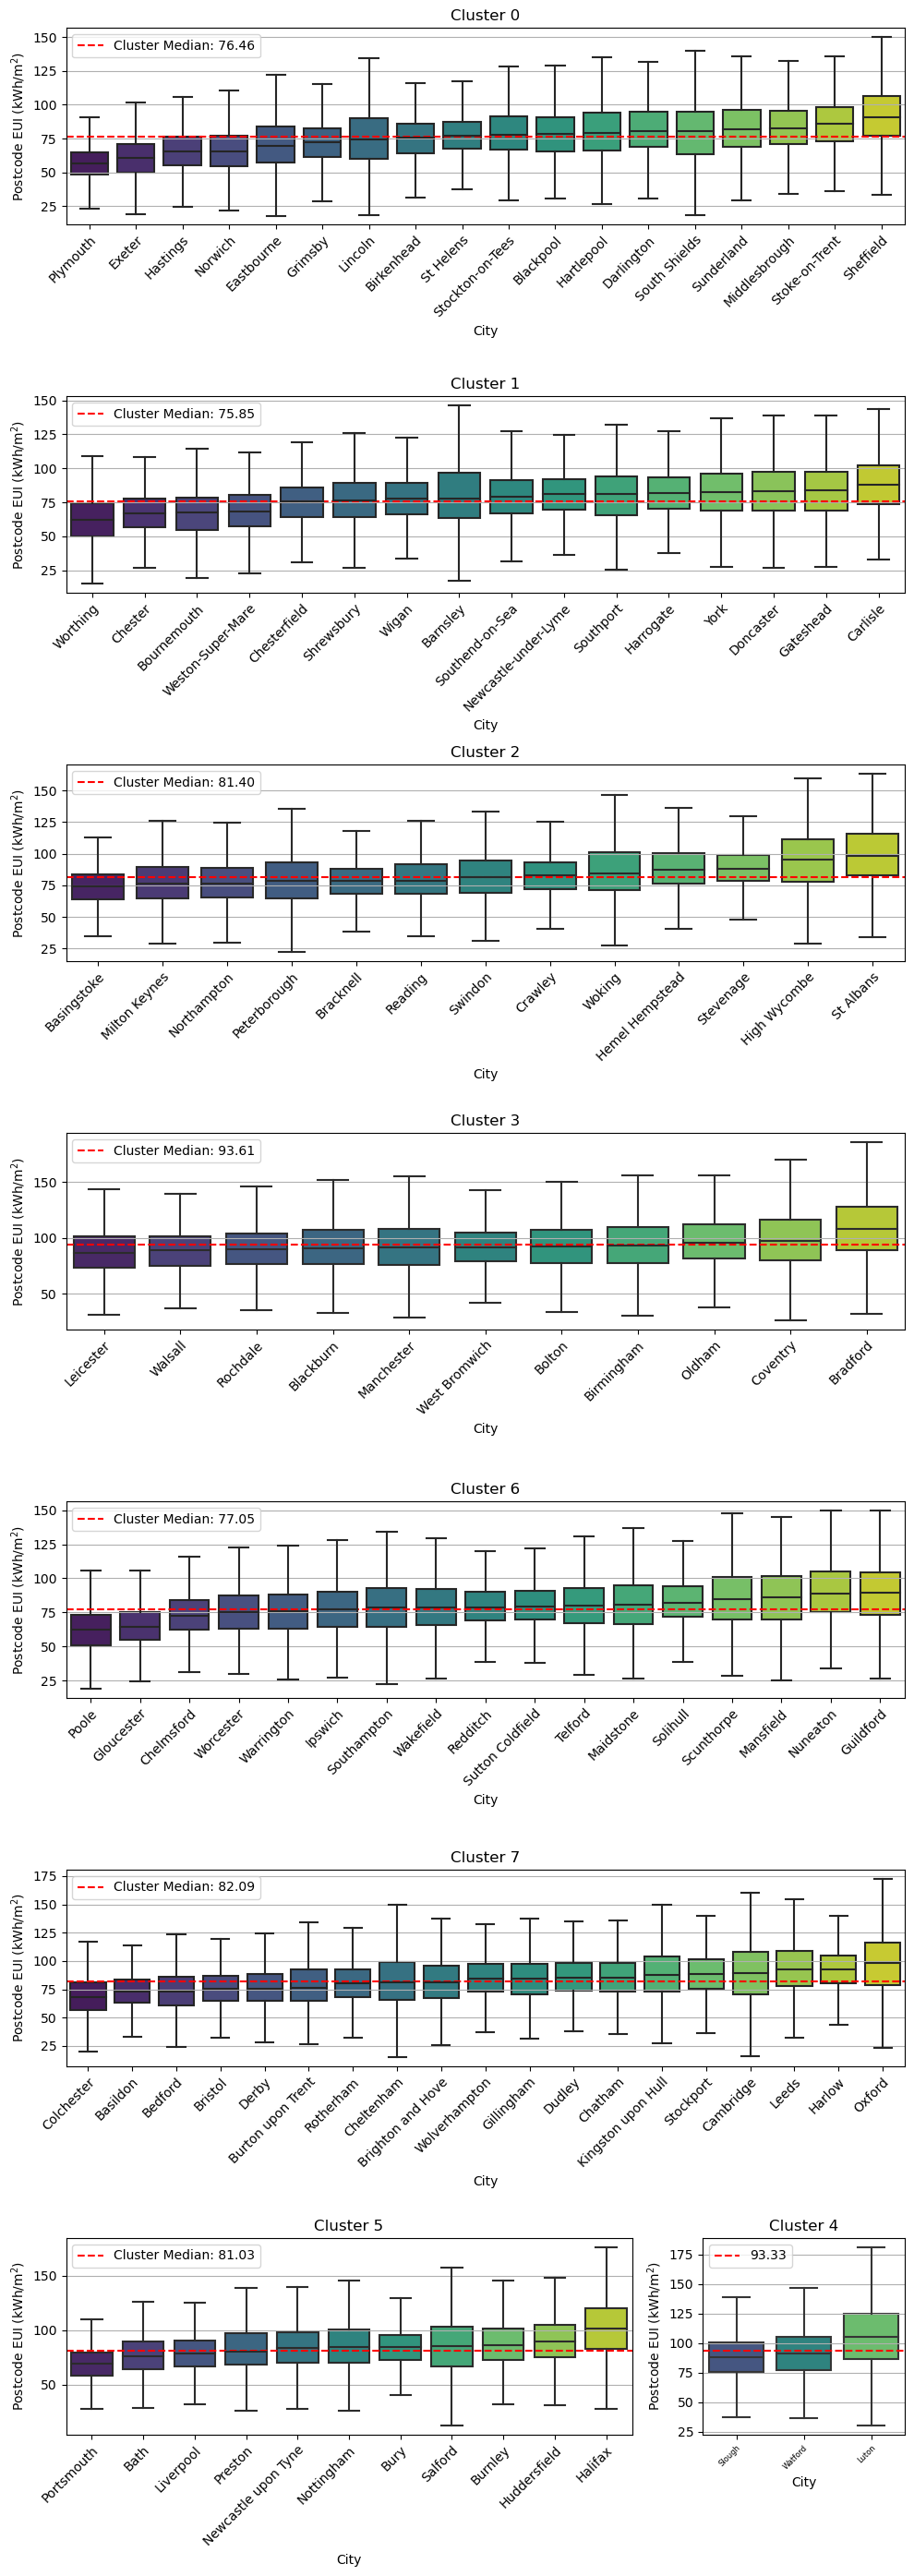

KeyError: 'Column not found: mean_av_gas'

In [17]:
import pandas as pd

def extract_boxplot_data(df, n, plotting_col):
    cluster_order = [0, 1, 2, 3, 6, 7, 5, 4]
    all_cluster_data = {}

    for quartile in cluster_order:
        dd = df[df['Cluster'] == quartile]
        
        # Group by city and calculate statistics
        city_stats = dd.groupby('TCITY15NM')[plotting_col].agg(['mean', 'median', 
                                                                lambda x: x.quantile(0.25),
                                                                lambda x: x.quantile(0.75)])
        
        # Rename columns
        city_stats.columns = ['mean', '50th_percentile', '25th_percentile', '75th_percentile']
        
        # Sort by median (50th percentile)
        city_stats = city_stats.sort_values('50th_percentile')
        
        # Store data for this cluster
        all_cluster_data[f'Cluster_{quartile}'] = city_stats

    return all_cluster_data

# Example usage:
wrkv0['mean_av_gas'] = (wrkv0['min_gas_per_vol'] + wrkv0['max_gas_per_vol']) / 2 
n = 8
city = 'V66'
folder = 'v3'
cdf = run_cluster(n, wrkv0, city, folder, typ='new', plotting_col='mean_av_gas')

# Extract data
boxplot_data = extract_boxplot_data(cdf, n, 'mean_av_gas')

# Print or further process the data
for cluster, data in boxplot_data.items():
    print(f"\n{cluster}:")
    print(data)

Len on input data is 621415


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/4217943415.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_37708/4217943415.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_3

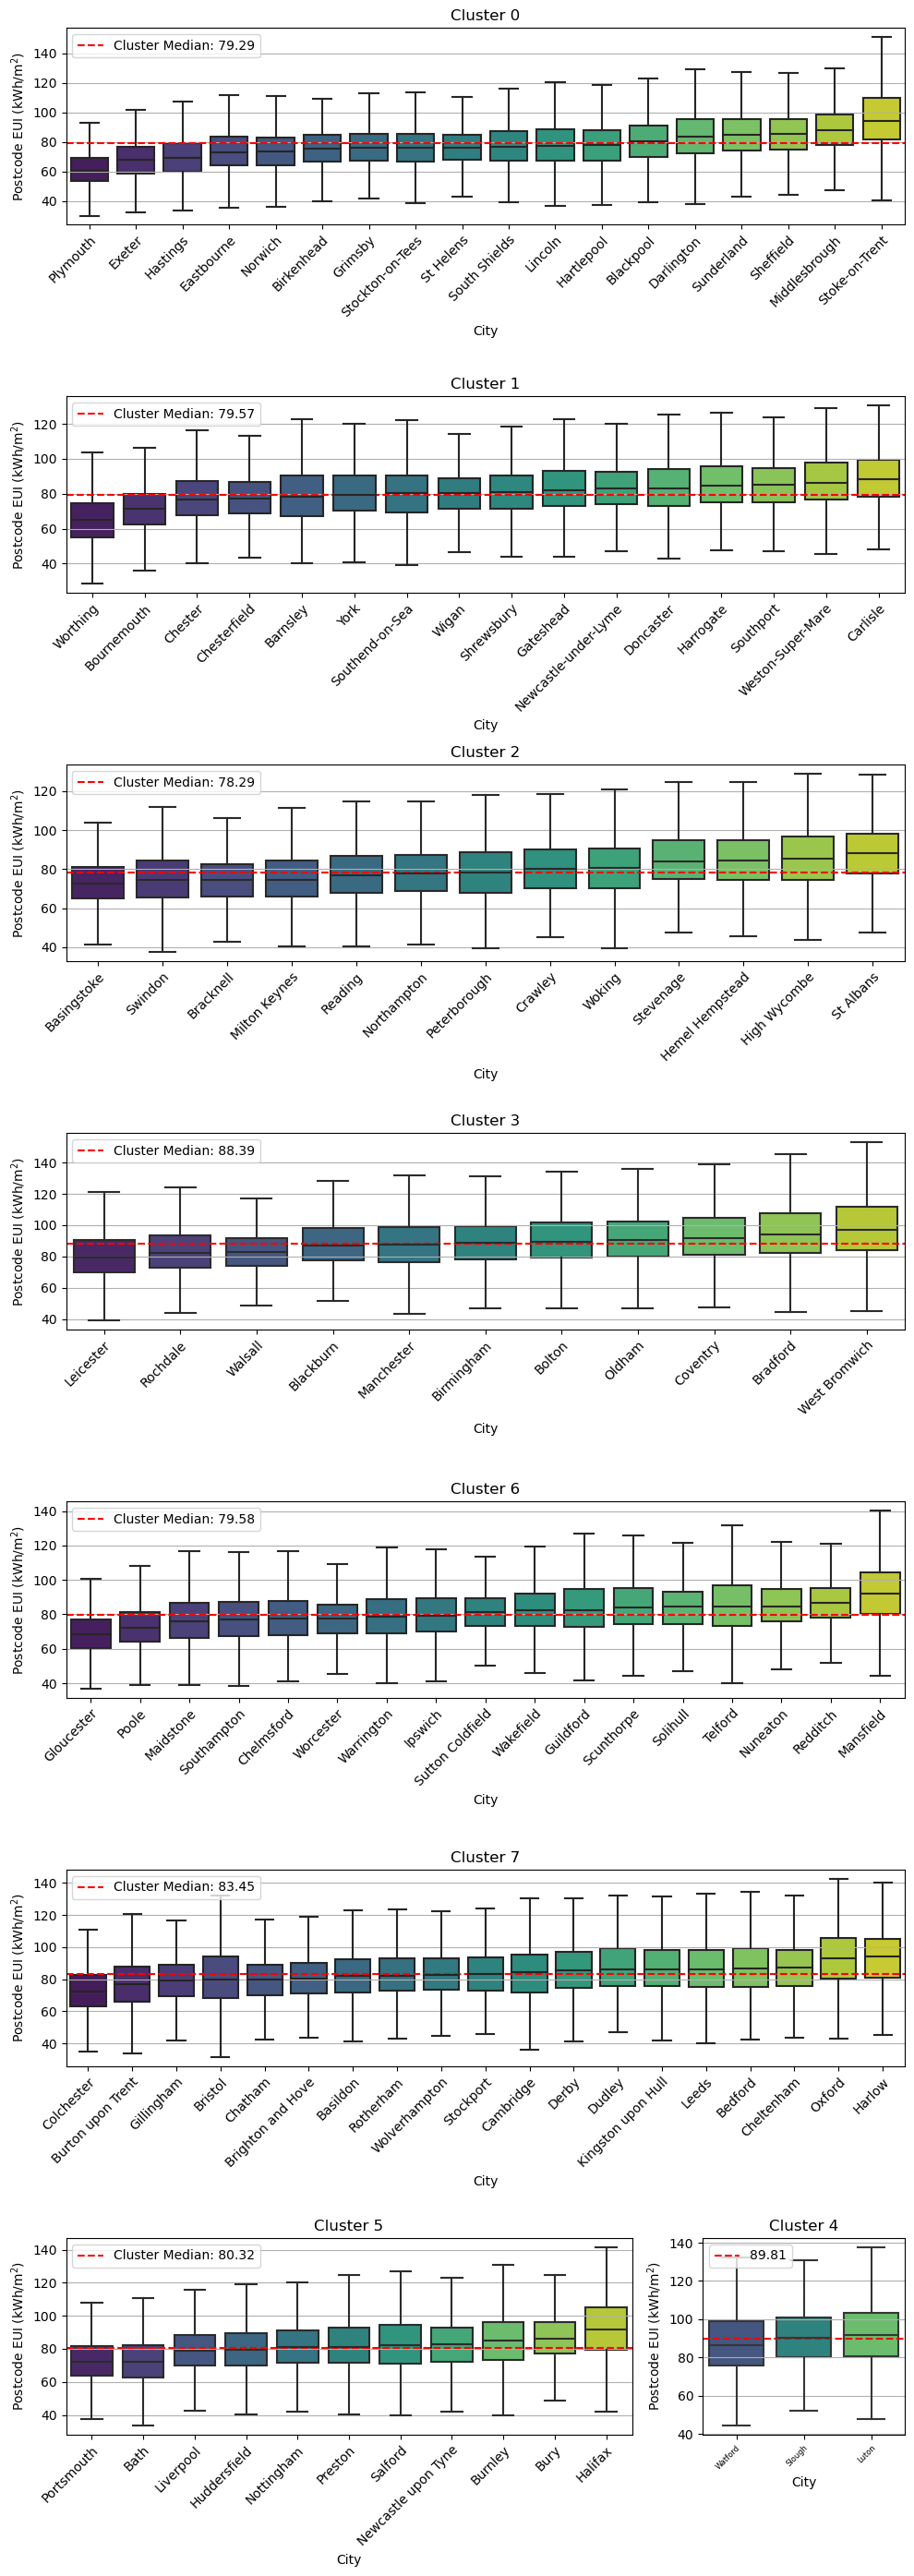

In [16]:
wrkv1['mean_av_gas'] = (wrkv1['min_gas_per_vol'] + wrkv0['max_gas_per_vol']) /2 
cdf = run_cluster( n, wrkv1 , city, folder, typ ='new', plotting_col = 'mean_av_gas')

In [79]:
# def plot_boxplot_cities(df, n, plotting_col):
#     fig = plt.figure(figsize=(10, 28))  # Adjusted figure size

#     # Define GridSpec for the layout
#     gs = GridSpec(7, 10, figure=fig, height_ratios=[1, 1, 1, 1, 1, 1, 1])

#     # Define the desired order of clusters
#     cluster_order = [0, 1,2,3,6,7,5,4 ]

#     for i, quartile in enumerate(cluster_order):
#         dd = df[df['Cluster'] == quartile]

#         medians = dd.groupby('TCITY15NM')[plotting_col].median().reset_index()
#         medians = medians.sort_values(by=plotting_col)

#         dd['TCITY15NM'] = pd.Categorical(dd['TCITY15NM'], categories=medians['TCITY15NM'], ordered=True)
#         dd = dd.sort_values('TCITY15NM')

#         quartile_median = dd[plotting_col].median()

#         # Create subplot
#         if i < 6:
#             ax = fig.add_subplot(gs[i, :])
#         elif i == 6:
#             ax = fig.add_subplot(gs[6, :7])  # 70% width
#         else:
#             ax = fig.add_subplot(gs[6, 7:])  # 30% width

#         sns.boxplot(x='TCITY15NM', y=plotting_col, data=dd, palette='viridis', ax=ax, showfliers=False)

#         if quartile == 4:
#             ax.axhline(quartile_median, color='red', linestyle='--', label=f'{quartile_median:.2f}')
#         else:
#             ax.axhline(quartile_median, color='red', linestyle='--', label=f'Cluster Median: {quartile_median:.2f}')

#         ax.set_title(f'Cluster {quartile}')
#         ax.set_ylabel('Postcode EUI (kWh/m$^2$)')
#         ax.set_xlabel('City')

#         for label in ax.get_xticklabels():
#             label.set_rotation(45)
#             label.set_horizontalalignment('right')
#             label.set_verticalalignment('top')
#             label.set_rotation_mode('anchor')

#         ax.legend(loc='upper left')
#         ax.yaxis.grid(True)

#         # Adjust x-axis labels for the smaller plot
#         if i == 7:  # For the last (smaller) plot
#             ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)

#     plt.tight_layout()
#     plt.show()
# # Example usage:
# wrkv0['mean_av_gas'] = (wrkv0['min_gas_per_vol'] + wrkv0['max_gas_per_vol']) /2 
# n= 8
# city = 'V66'
# folder = 'final'
# cdf = run_cluster( n, wrkv0 , city, folder, typ ='new', plotting_col = 'mean_av_gas')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/gracecolverd/New_dataset/ml_scripts/final/V66_city_clust.csv'

In [80]:
# # add length of cluster÷ 
# count = cdf.groupby('Cluster').count().reset_index()
# dist = cdf.drop(columns=['Unnamed: 0']).groupby('Cluster').mean().round(1)

# dist['Num_members'] = count['TCITY15NM']
# dist[['Num_members'] +  dist.columns.tolist() ].round(1).to_csv('V66_cluster_summary.csv')

AttributeError: 'NoneType' object has no attribute 'groupby'

In [ ]:

# # Example usage:
# wrkv0['mean_av_gas'] = (wrkv0['min_gas_per_vol'] + wrkv0['max_gas_per_vol']) /2 
# n= 8
# city = 'V66'
# folder = 'v3'
# run_cluster( n, wrkv0 , city, folder, typ ='new', plotting_col = 'mean_av_gas')

Len on inut data is  657731


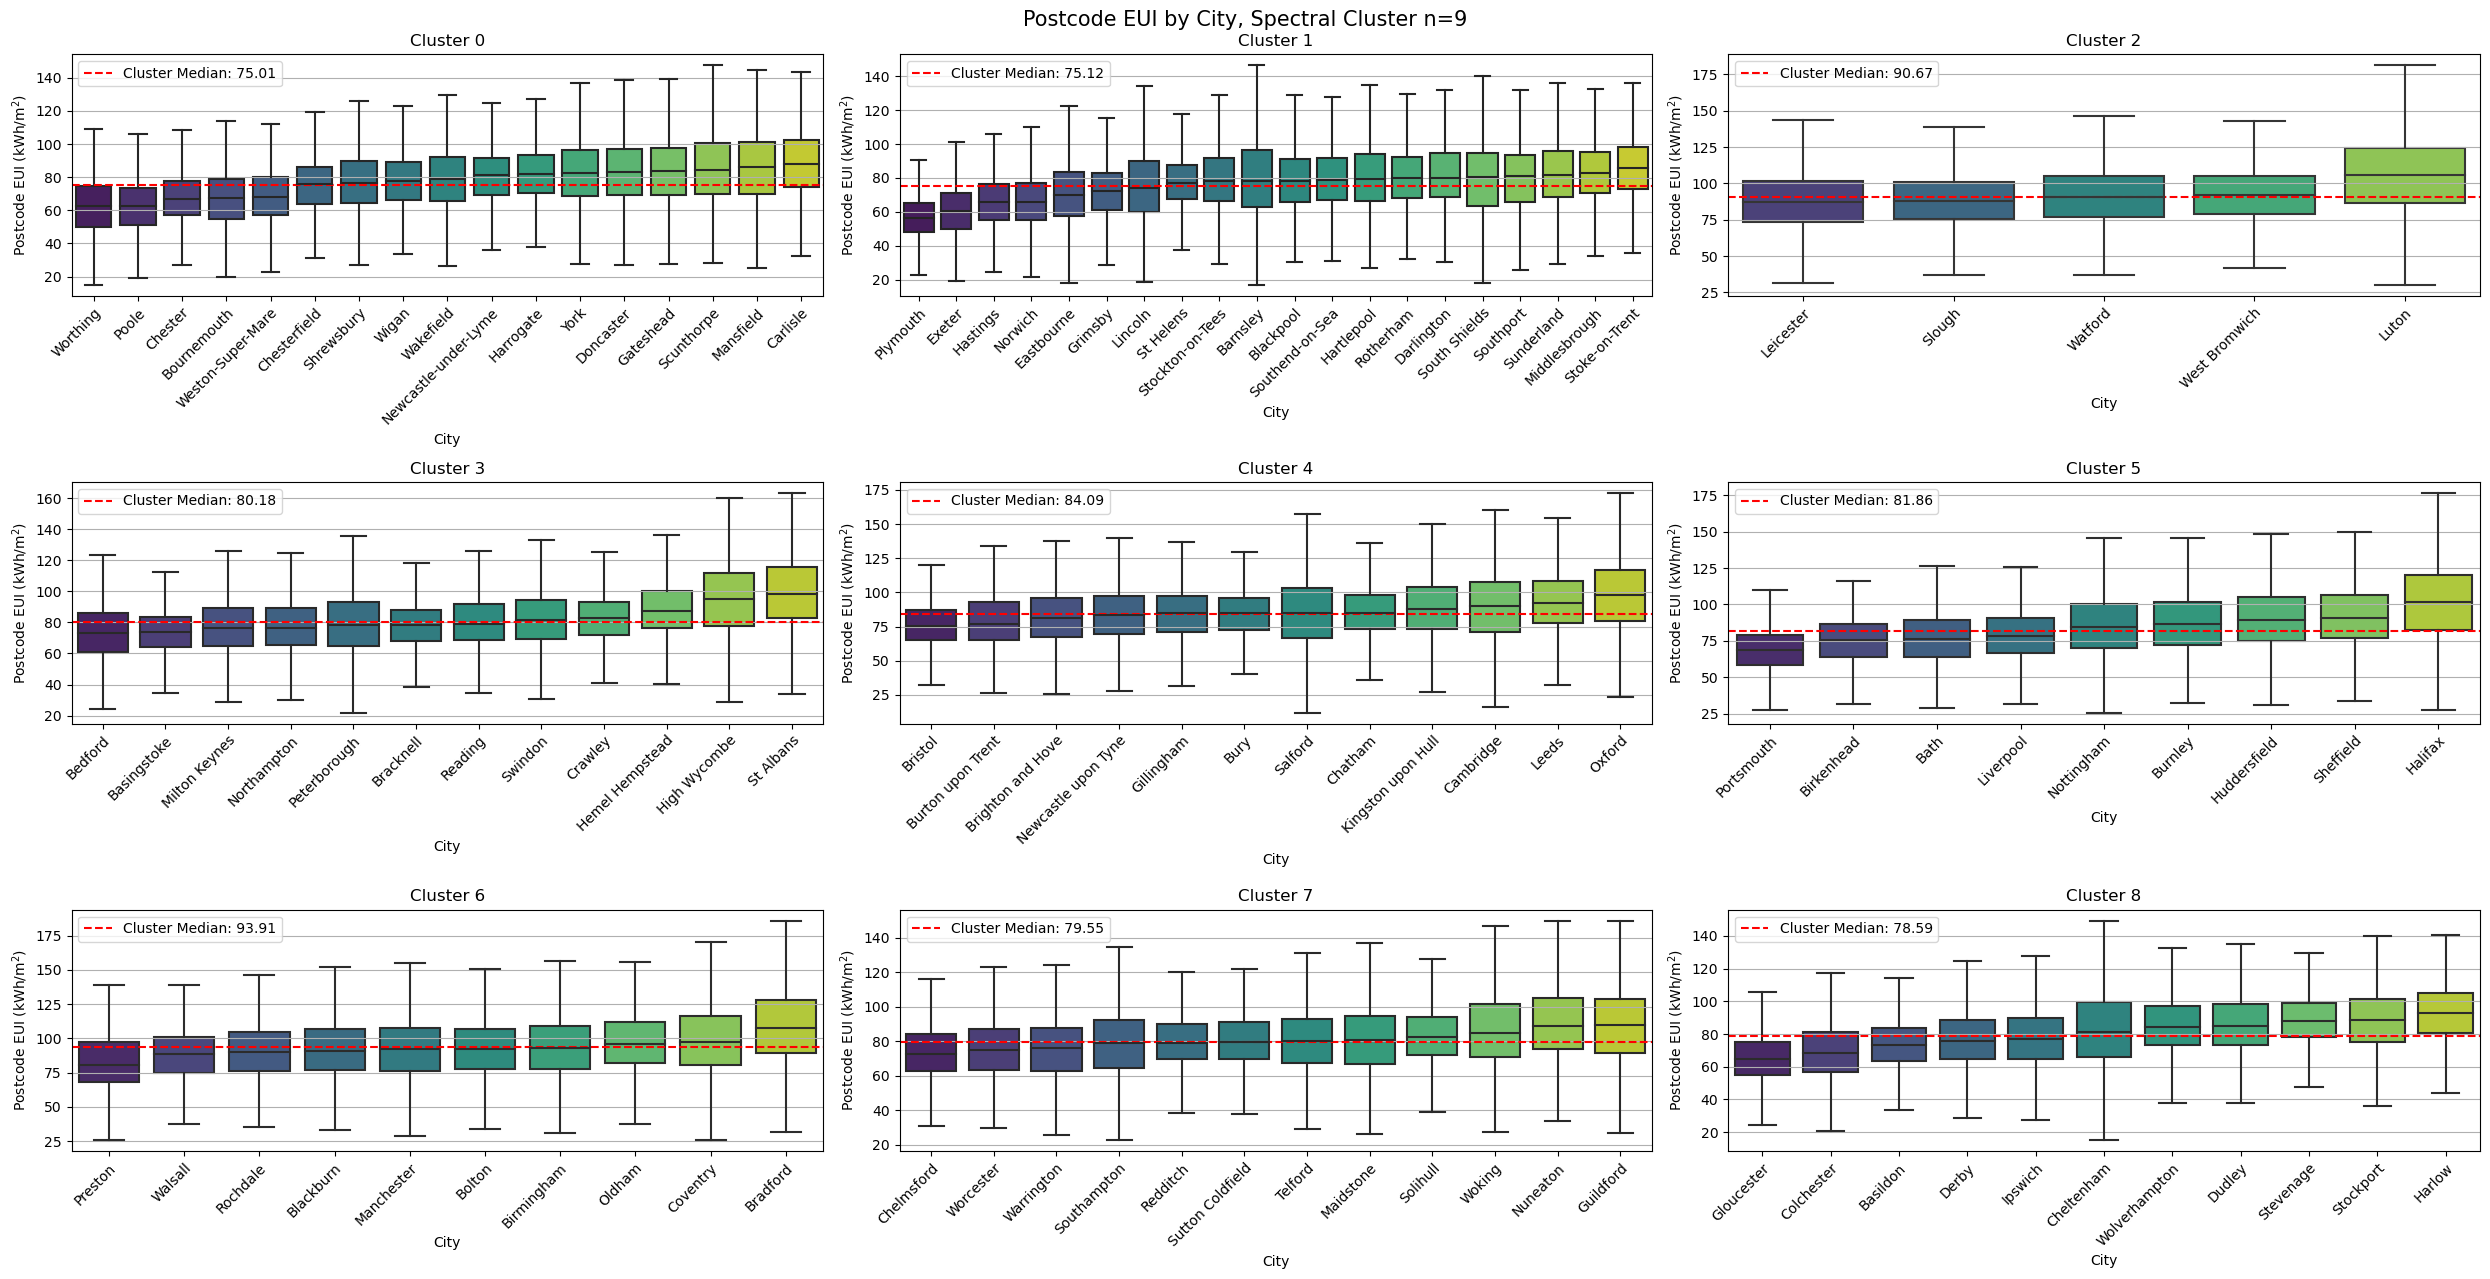

In [41]:
# wrkv0['mean_av_gas'] = (wrkv0['min_gas_per_vol'] + wrkv0['max_gas_per_vol']) /2 
# n= 9
# city = 'V55'
# folder = 'v3_citycluster_all'
# run_cluster( n, wrkv0 , city, folder, typ ='new', plotting_col = 'mean_av_gas')

In [10]:

def plot_variable_distributions(X_train, labels, run_path, cols):
    """
    Plot the KDE distributions of variables for each cluster in a figure with three columns and multiple rows.
    
    Parameters:
    X_train (pd.DataFrame): The training data.
    labels (np.array): The cluster labels.
    run_path (str): The path to save the plots.
    cols (list): The columns to plot.
    """
    # Get the variables and labels
    df = pd.DataFrame(X_train, columns=cols)
    df['Cluster'] = labels
    
    # Create a subfolder for the plots
    plots_folder = os.path.join(run_path, 'variable_distributions')
    os.makedirs(plots_folder, exist_ok=True)
    
    # Determine the number of rows needed for 3 columns
    num_cols = 2
    num_rows = (len(cols) + num_cols - 1) // num_cols  # Ceiling division
    
    # Create the figure with the required number of subplots
    plt.figure(figsize=(20, 5 * num_rows))
    
    for i, col in enumerate(cols):
        plt.subplot(num_rows, num_cols, i + 1)
        for cluster in np.unique(labels):
            cluster_data = df[df['Cluster'] == cluster][col].dropna()
            sns.kdeplot(cluster_data, fill=True, label=f'Cluster {cluster}')
        plt.title(f'Distribution of {col} by Cluster')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
    
    # plt.tight_layout()
    # plt.savefig(os.path.join(plots_folder, 'all_distributions.png'))
    # plt.close()


In [ ]:
plot_variable_distributions()

In [39]:
n= 10
city = 'V53'
folder = 'v0_citycluster_all'
run_cluster( n, wrk , city, folder, typ ='new')

NameError: name 'wrk' is not defined

Len on inut data is  544170


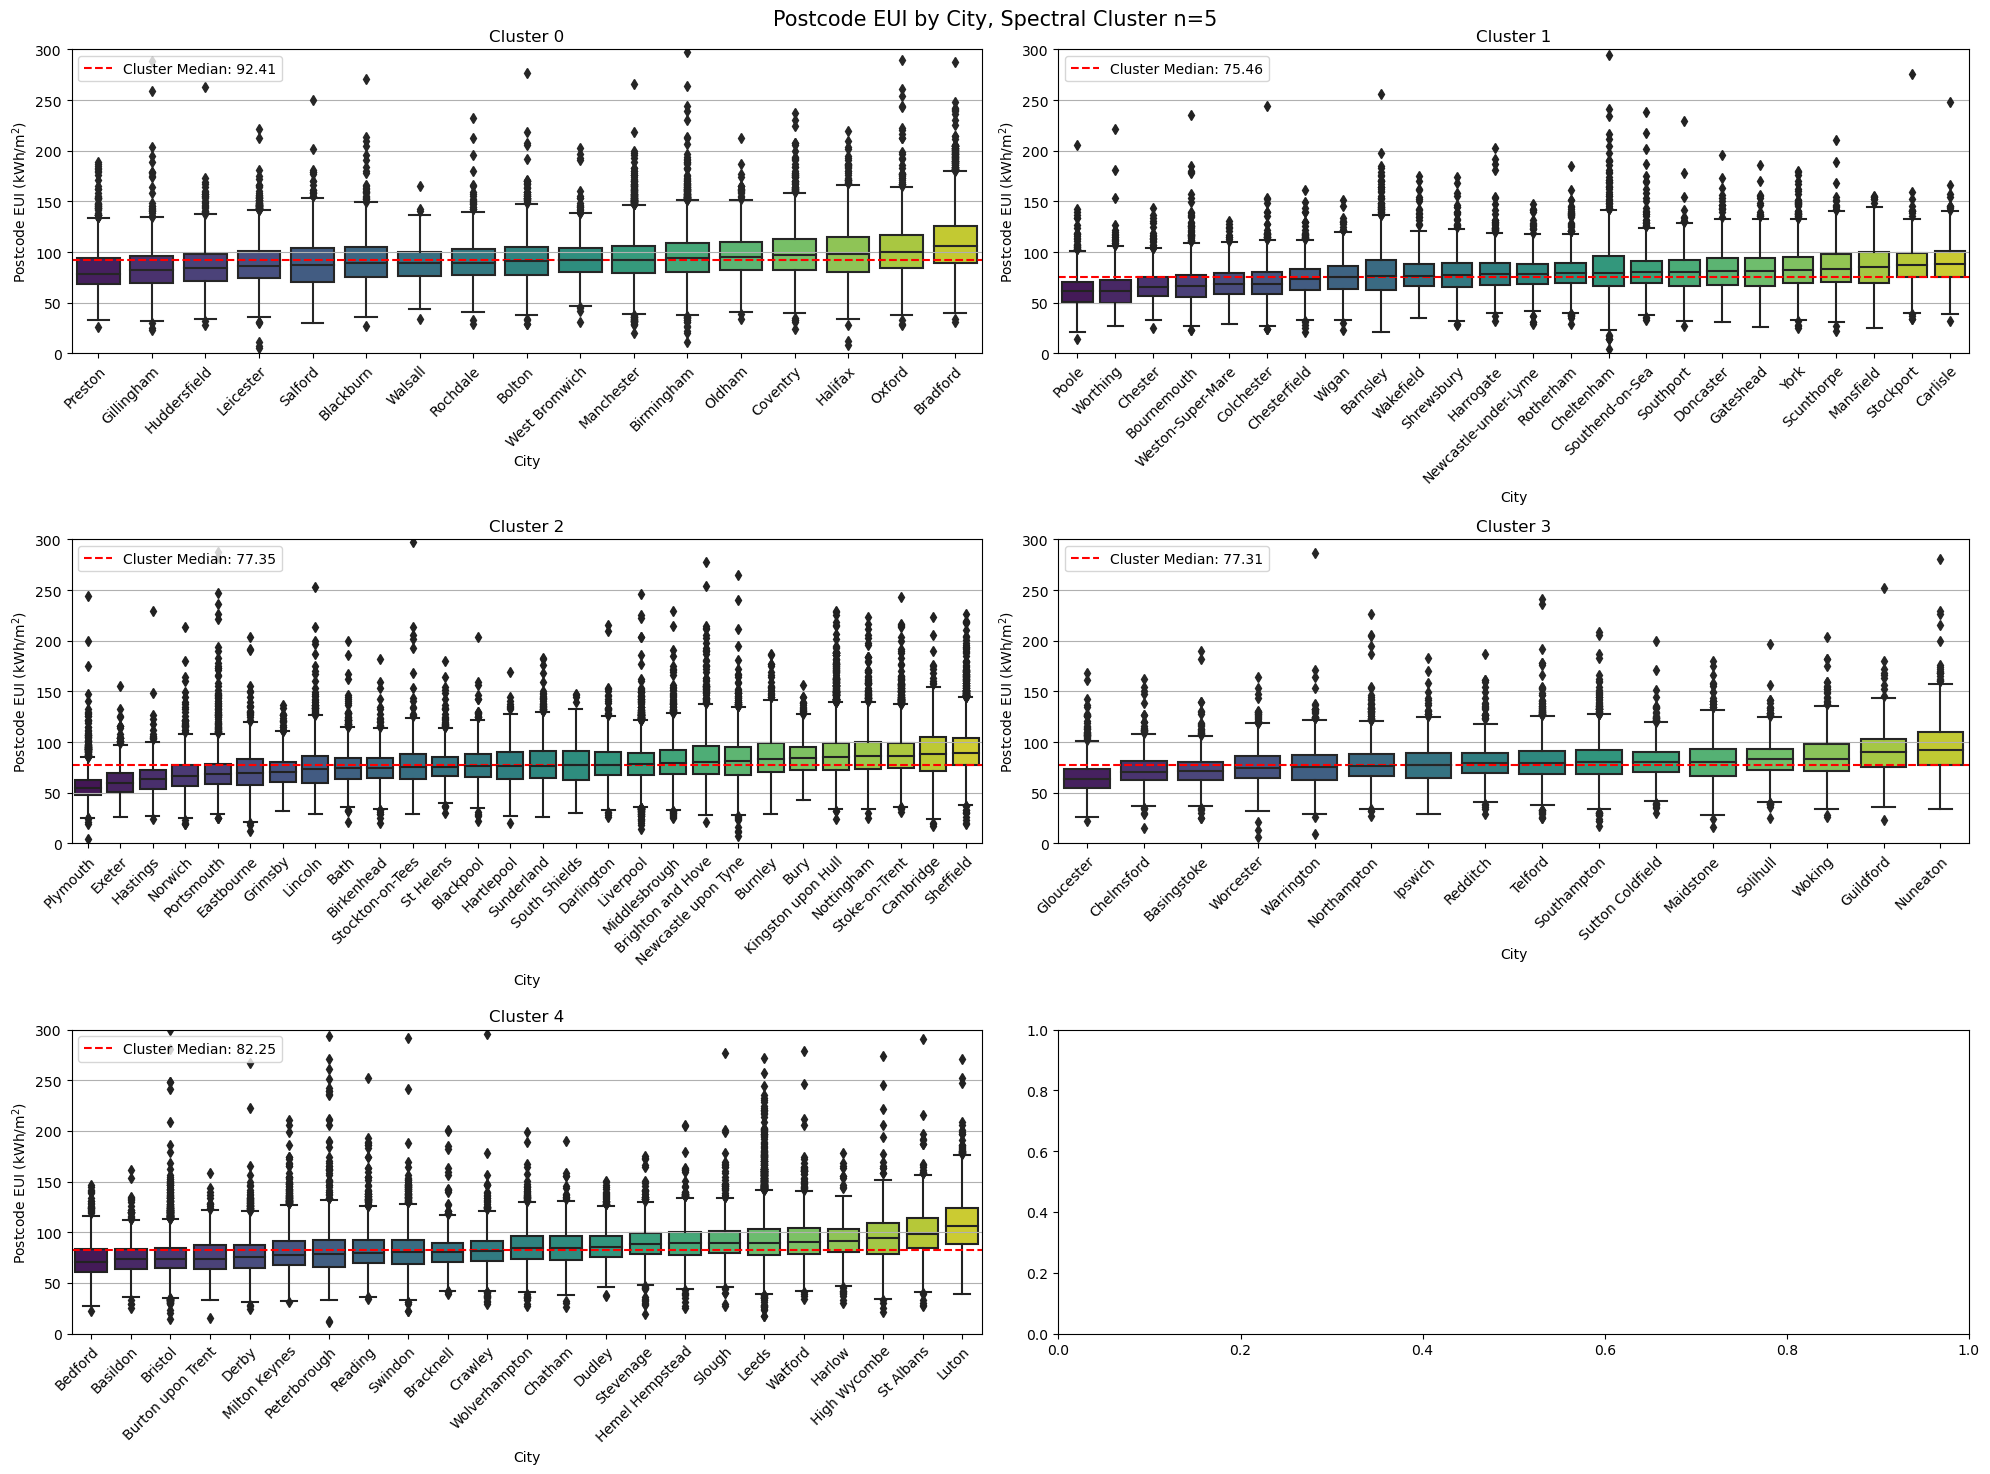

In [59]:
n= 5
city = 'V55'
folder = 'citycluster_all'
run_cluster( n, wrk , city, folder, typ ='new')

In [1]:
# n= 8
# city = 'V71'
# folder = 'cityfinalv2'
# run_cluster( n, wrk , city, folder, typ ='new')

In [2]:
# n= 8
# city = 'V61'
# folder = 'cityfinalv2'
# run_cluster( n, wrk , city, folder, typ ='new')

In [3]:
# n= 8
# city = 'V51'
# folder = 'cityfinalv2'
# run_cluster( n, wrk , city, folder, typ ='new')

In [4]:
# n= 8
# city = 'V46'
# folder = 'cityfinalv2'
# run_cluster( n, wrk , city, folder, typ ='new')

Len on inut data is  543732


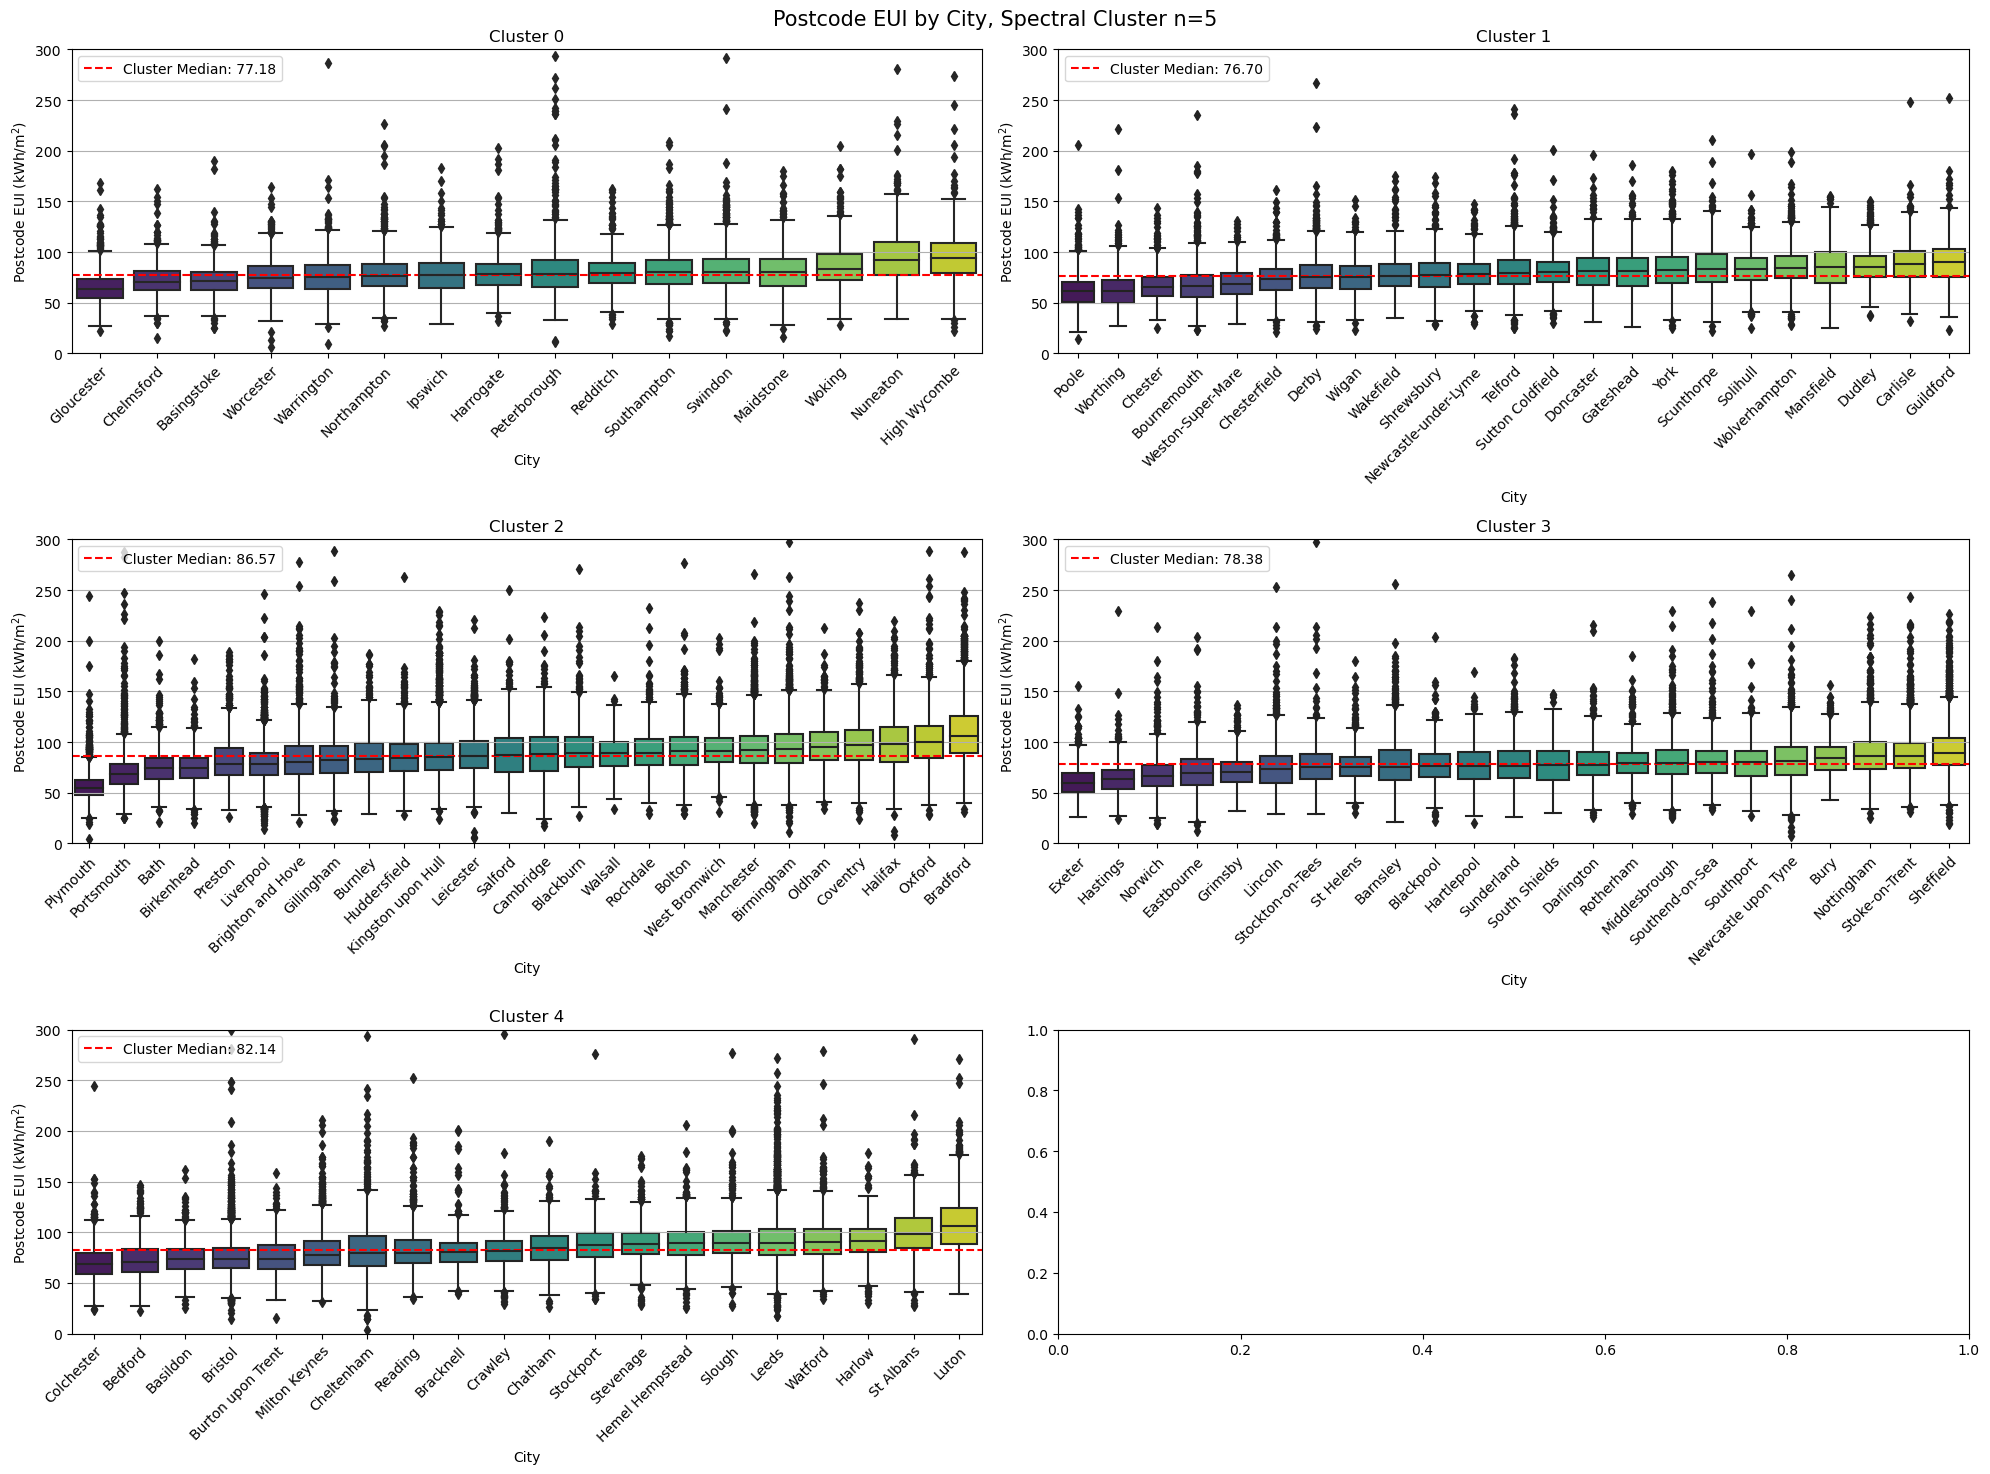

In [9]:
n= 5
city = 'V49'
folder = 'cityfinalv2'
run_cluster( n, wrk , city, folder, typ ='new')

In [5]:
# n= 5
# city = 'v81city'
# folder = 'cclust'
# run_cluster( n, wrk , city, folder, typ ='new')

In [6]:
# n= 5
# city = 'v82city'
# folder = 'cclust'
# run_cluster( n, wrk , city, folder, typ ='new')

In [7]:
# n= 5
# city = 'v83city'
# folder = 'cclust'
# run_cluster( n, wrk , city, folder, typ ='new')